From Supplementary Materials for
Genetic ancestry effects on the response to viral infection are pervasive but cell type specific


FASTQ files from each multiplexed capture library were mapped to a custom reference containing GRCh38 and the Cal/04/09 IAV reference genome (downloaded from NCBI, created using 8 cellranger mkref) using the cellranger (v3.0.2) (10X Genomics) count function (54) in --skip_remap mode (-k 6) was used to demultiplex cells into. souporcell (v2.0, Singularity v3.4.0) samples based on genotypes from a common variants file (1000GP samples filtered to SNPs with >= 2% allele frequency in the population, downloaded from https://github.com/wheaton5/souporcell). Briefly, souporcell clusters cells based on cell allele counts in common variants, assigning all cells with similar allele counts to a single cluster corresponding to one individual, while also estimating singlet/doublet/negative status for that cell. For each batch, hierarchical clustering of the true genotypes known for each individual (obtained from low-pass whole-genome-sequencing) and the cluster genotypes estimated from souporcell was used to assign individual IDs to souporcell cell clusters. All 89 individuals were successfully assigned to a single cluster.



After demultiplexing cells into samples, Seurat (v3.1.5, R v3.6.3) was used to perform quality control filtering of cells. In total, we captured 255,731 cells prior to filtering (range of cells recovered per capture: min. = 5,534, max. = 10,805).


Cells were considered “high-quality” and retained for downstream analysis if they had: 

1. a “singlet” status called by souporcell, 
1. between 200 – 2500 genes detected (nFeature_RNA), and 
1. a mitochondrial reads percentage < 10%, 

leaving 236,993 cells (n = 19,248 genes).

Based on https://broadinstitute.github.io/2020_scWorkshop/data-wrangling-scrnaseq.html

In [1]:
library(Seurat)
library(dplyr)
library(Matrix)
library(gdata)

Attaching SeuratObject

Attaching sp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.



gdata: Unable to load perl libaries needed by read.xls()
gdata: to support 'XLSX' (Excel 2007+) files.



gdata: Run the function 'installXLSXsupport()'
gdata: to automatically download and install the perl
gdata: libaries needed to support Excel XLS and XLSX formats.


Attaching package: ‘gdata’


The following objects are masked from ‘package:dplyr’:

    combine, first, last


The following object is masked from ‘package:stats’:

    nobs


The following object is masked from ‘package:utils’:

    object.size


The following object is masked from ‘package:base’:

    startsWith




In [2]:
counts <- Read10X(data.dir = "/Users/jake/github/ucsffrancislab/genomics/data/20220303-FluPaper/20220421-SingleCell/out/B1-c1/outs/filtered_feature_bc_matrix")


In [3]:
dim(counts)

[1] 63568  7165

In [4]:
original_barcode_count=ncol(counts)
original_barcode_count

[1] 7165

In [5]:
object.size(counts) # size in bytes

[1] 84661536 bytes

In [6]:
object.size(as.matrix(counts)) # size in bytes

[1] 3648727296 bytes

In [7]:
counts_per_cell <- Matrix::colSums(counts)
counts_per_gene <- Matrix::rowSums(counts)
genes_per_cell <- Matrix::colSums(counts>0) # count gene only if it has non-zero reads mapped.
cells_per_gene <- Matrix::rowSums(counts>0) # only count cells where the gene is expressed

In [8]:
options(repr.plot.width=16, repr.plot.height=8)

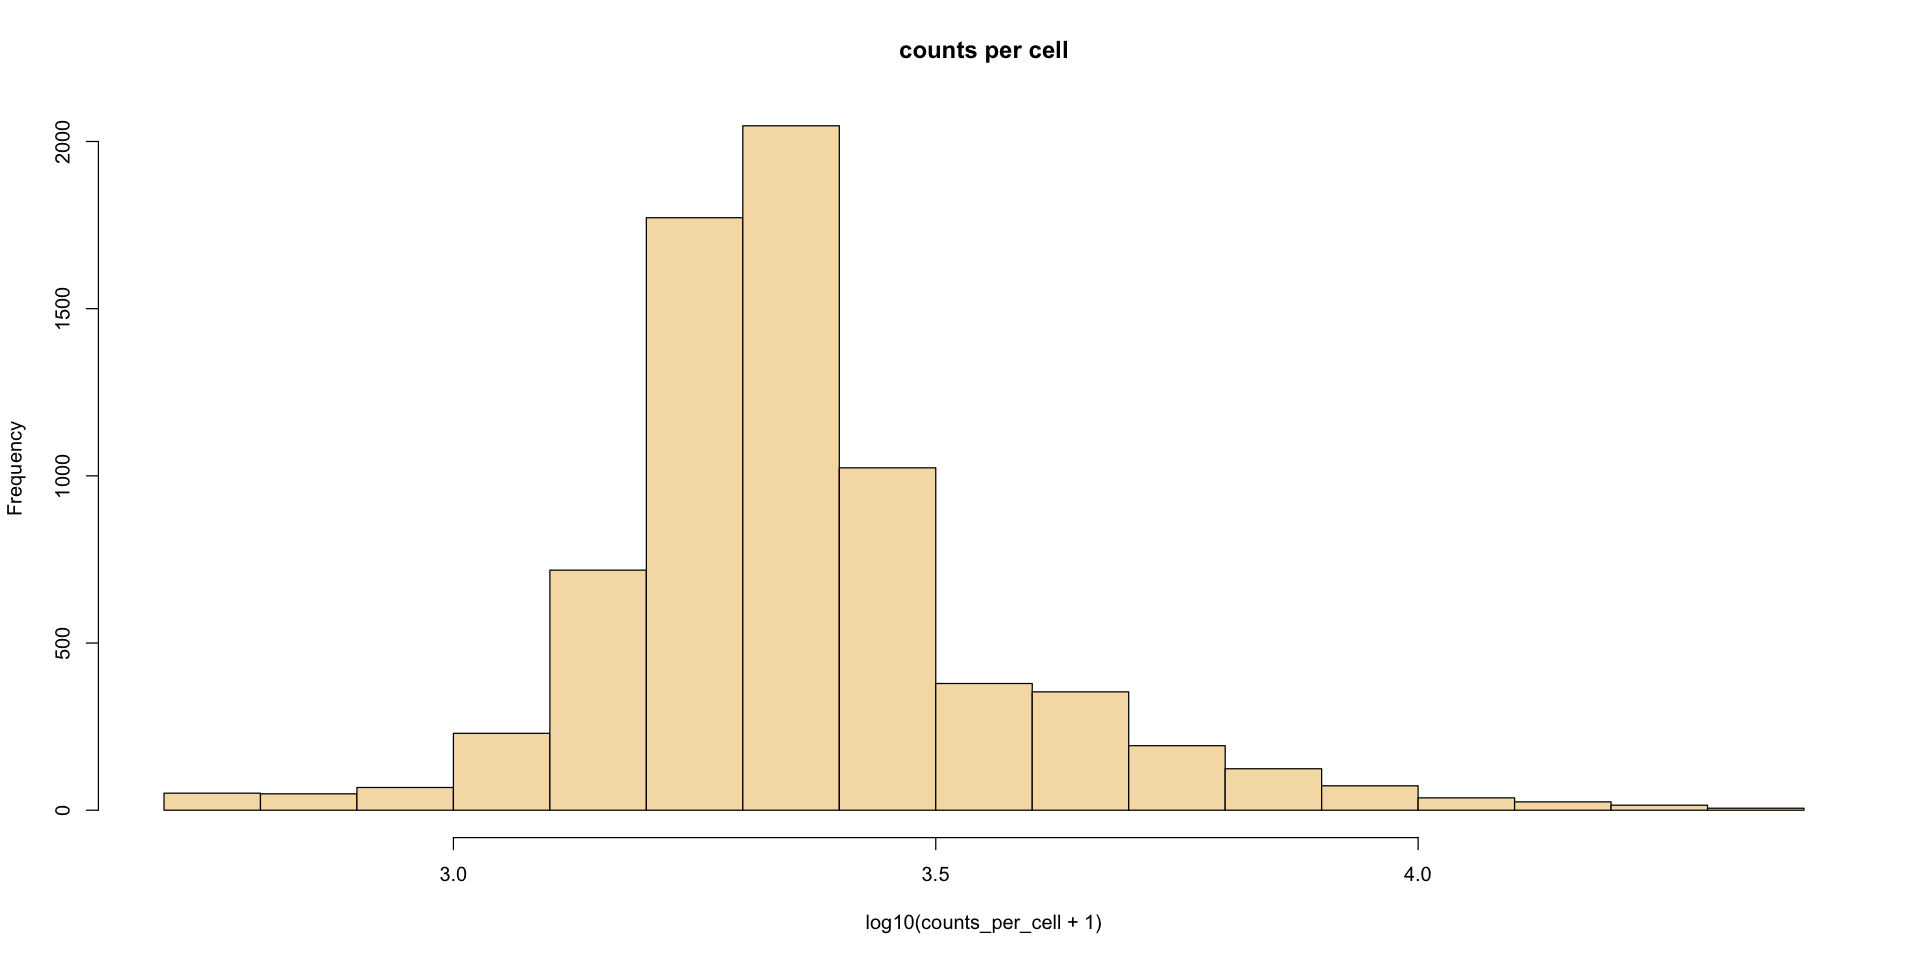

In [9]:
hist(log10(counts_per_cell+1), main='counts per cell', col='wheat')

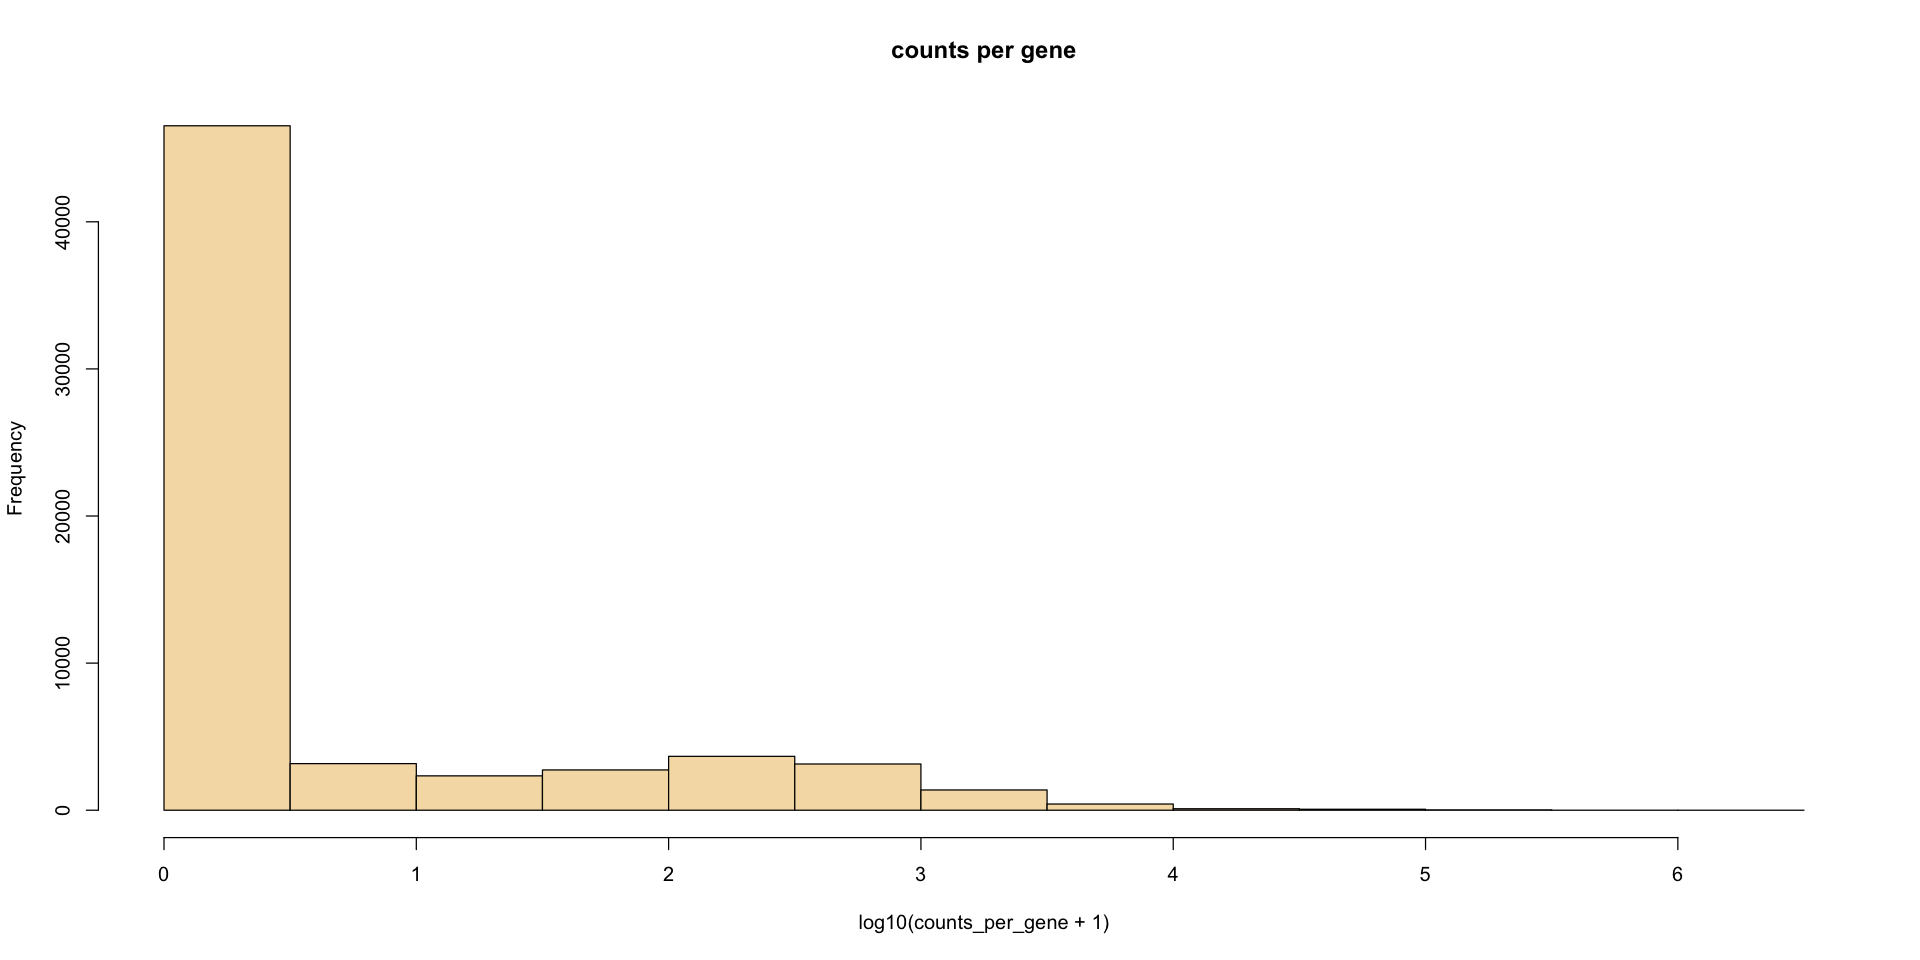

In [10]:
hist(log10(counts_per_gene+1), main='counts per gene', col='wheat')

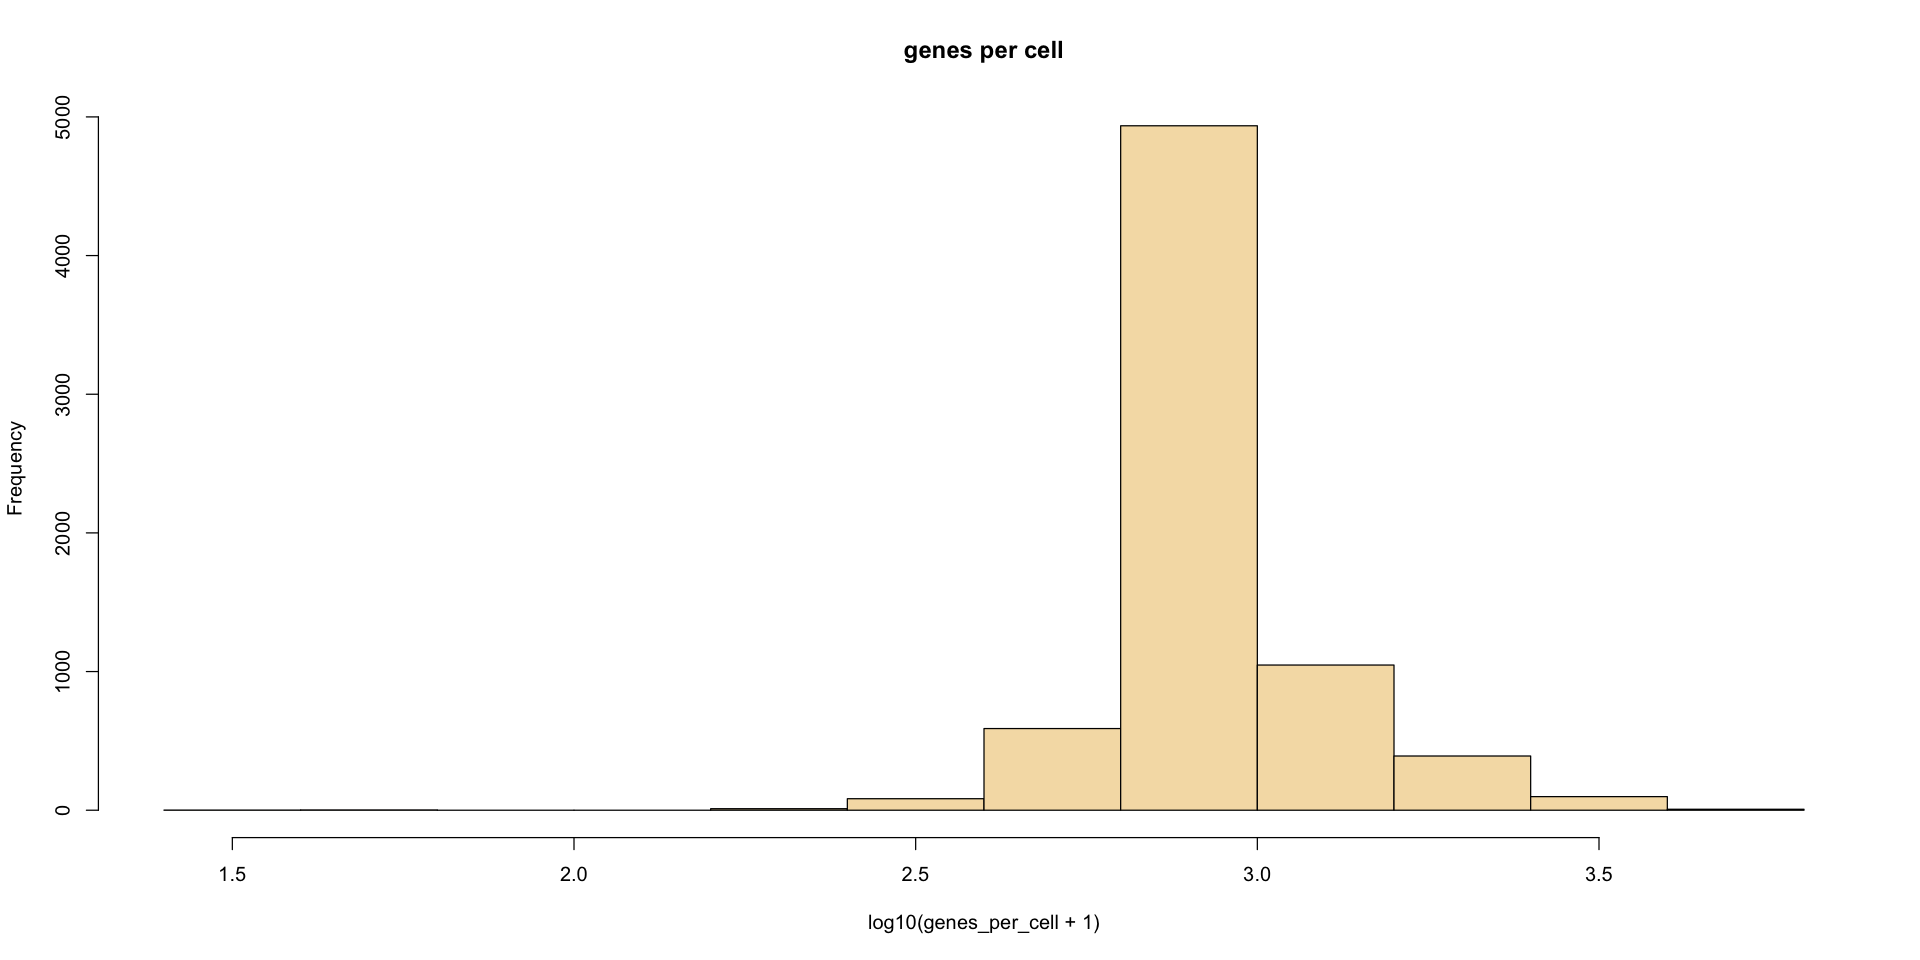

In [11]:
hist(log10(genes_per_cell+1), main='genes per cell', col='wheat')

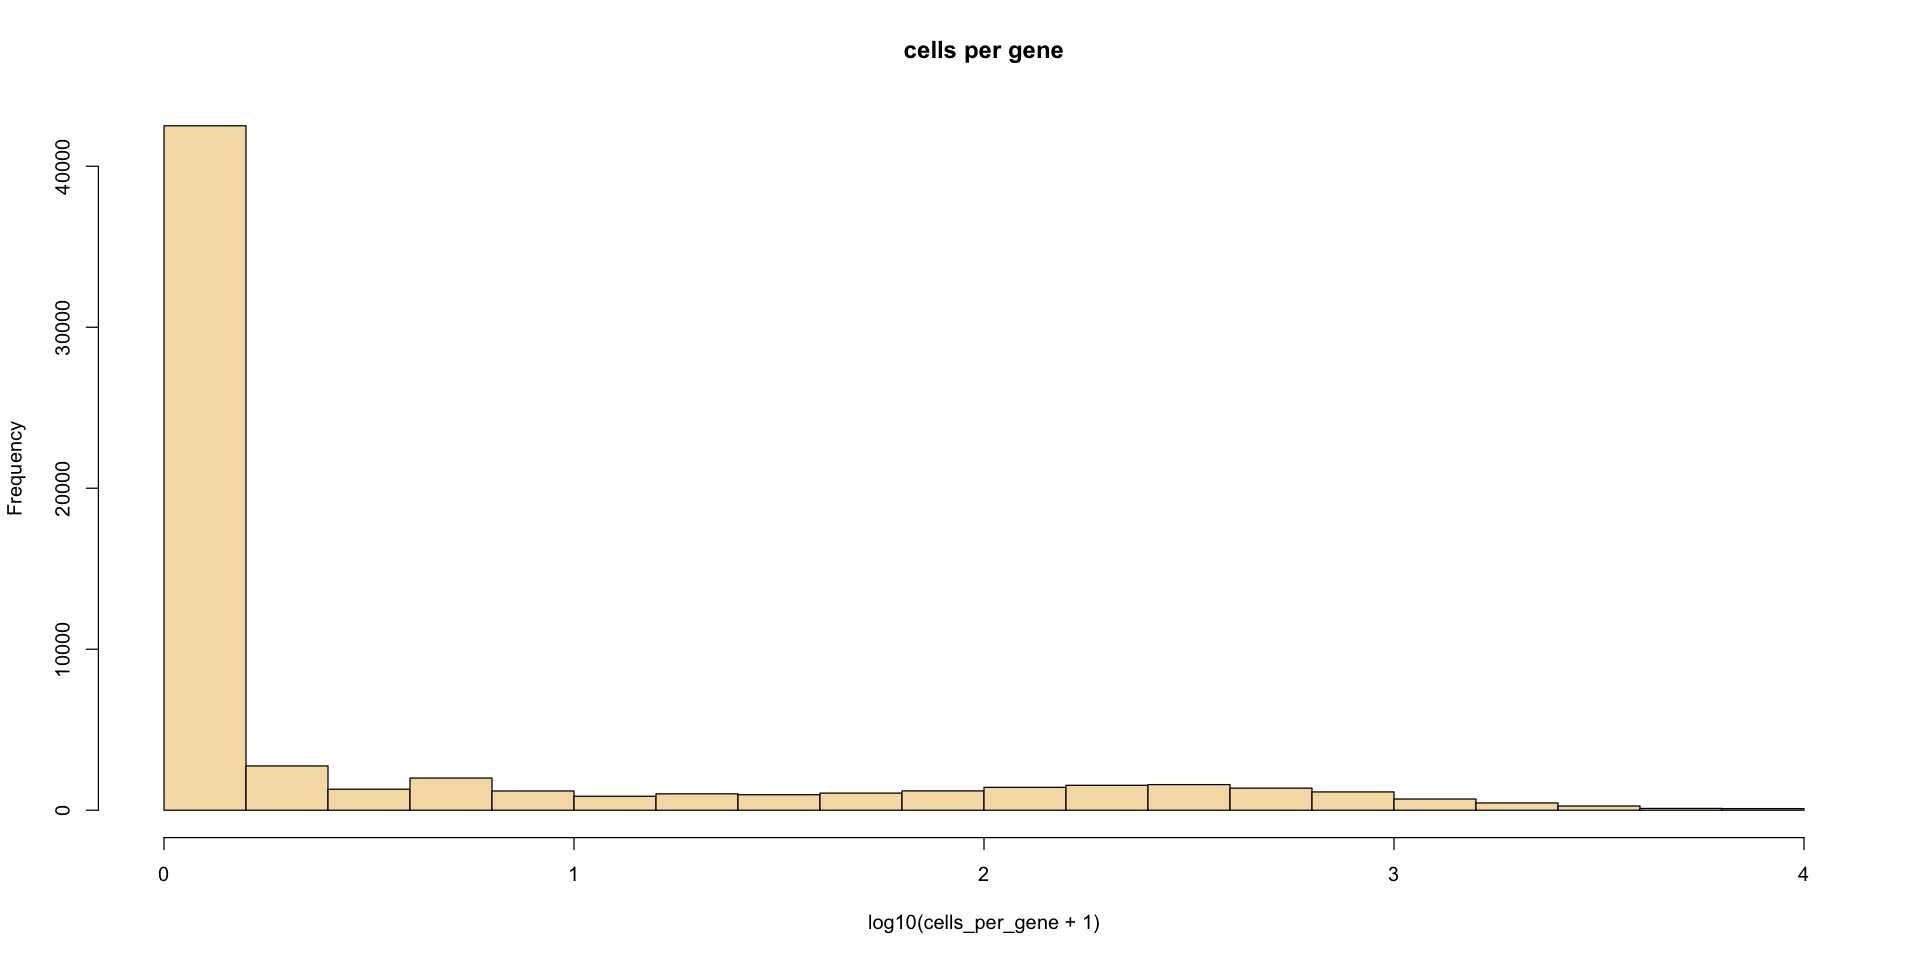

In [12]:
hist(log10(cells_per_gene+1), main='cells per gene', col='wheat')

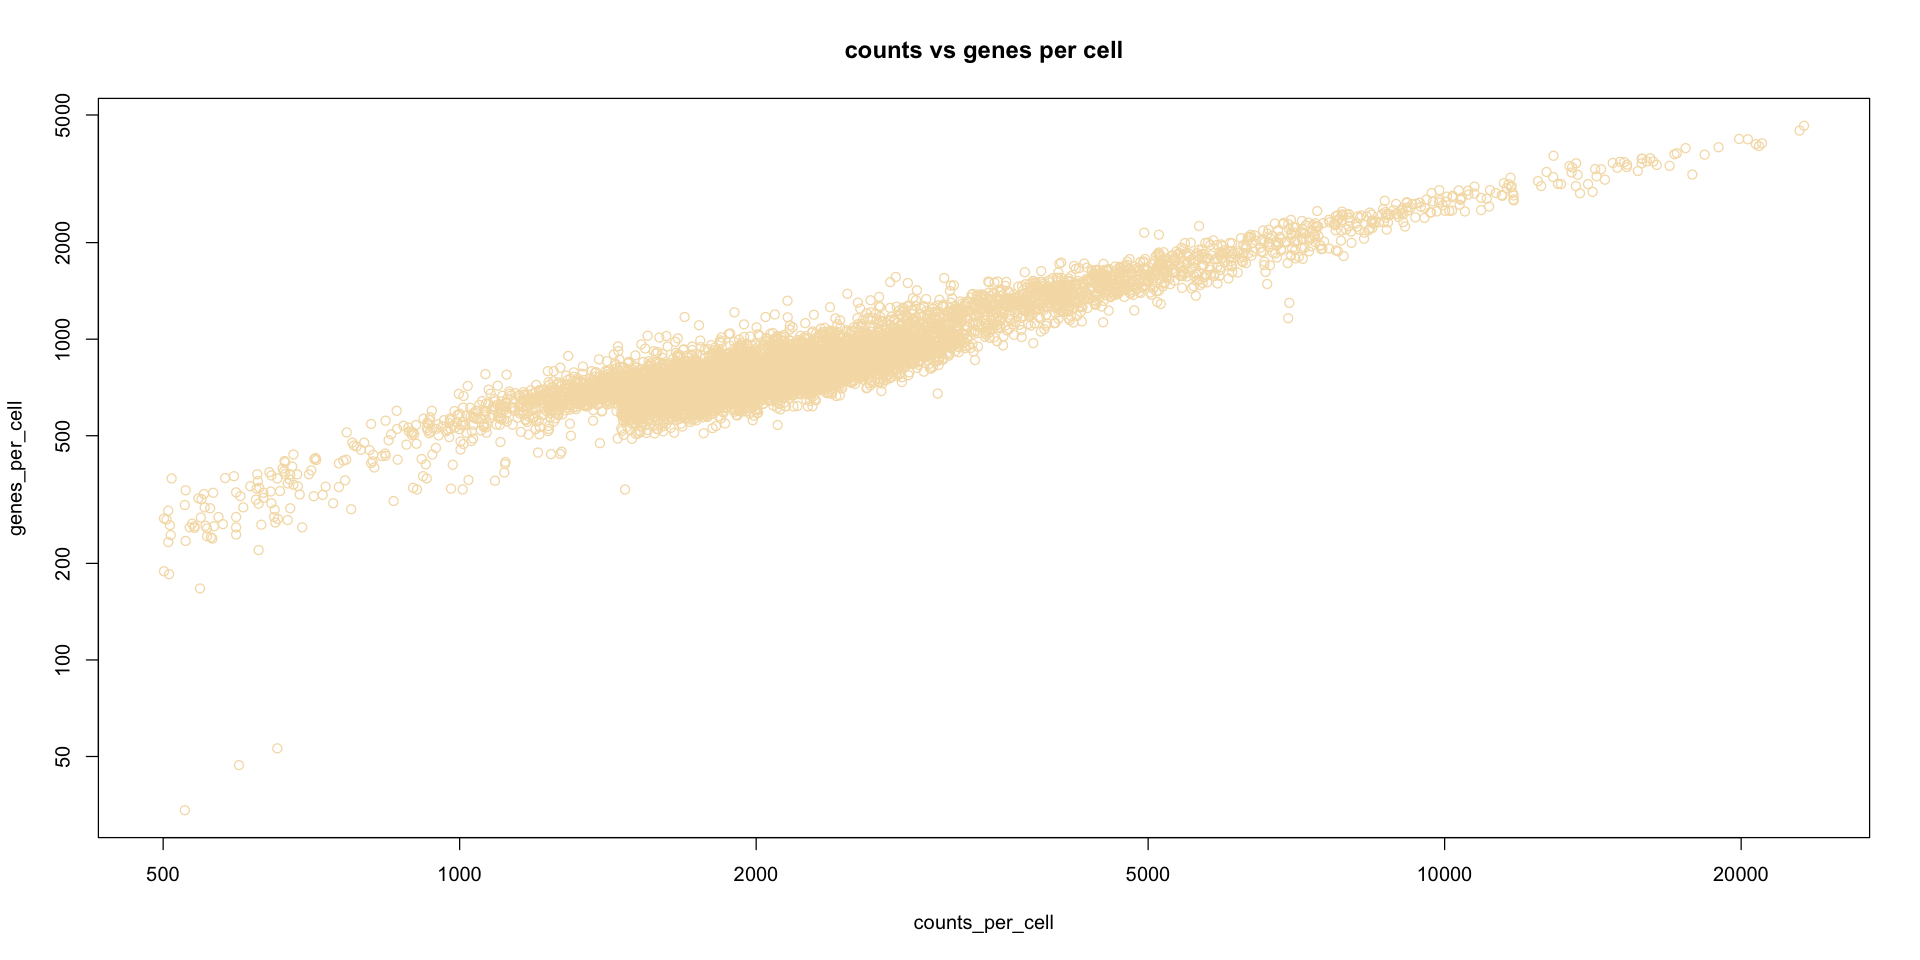

In [13]:
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell')

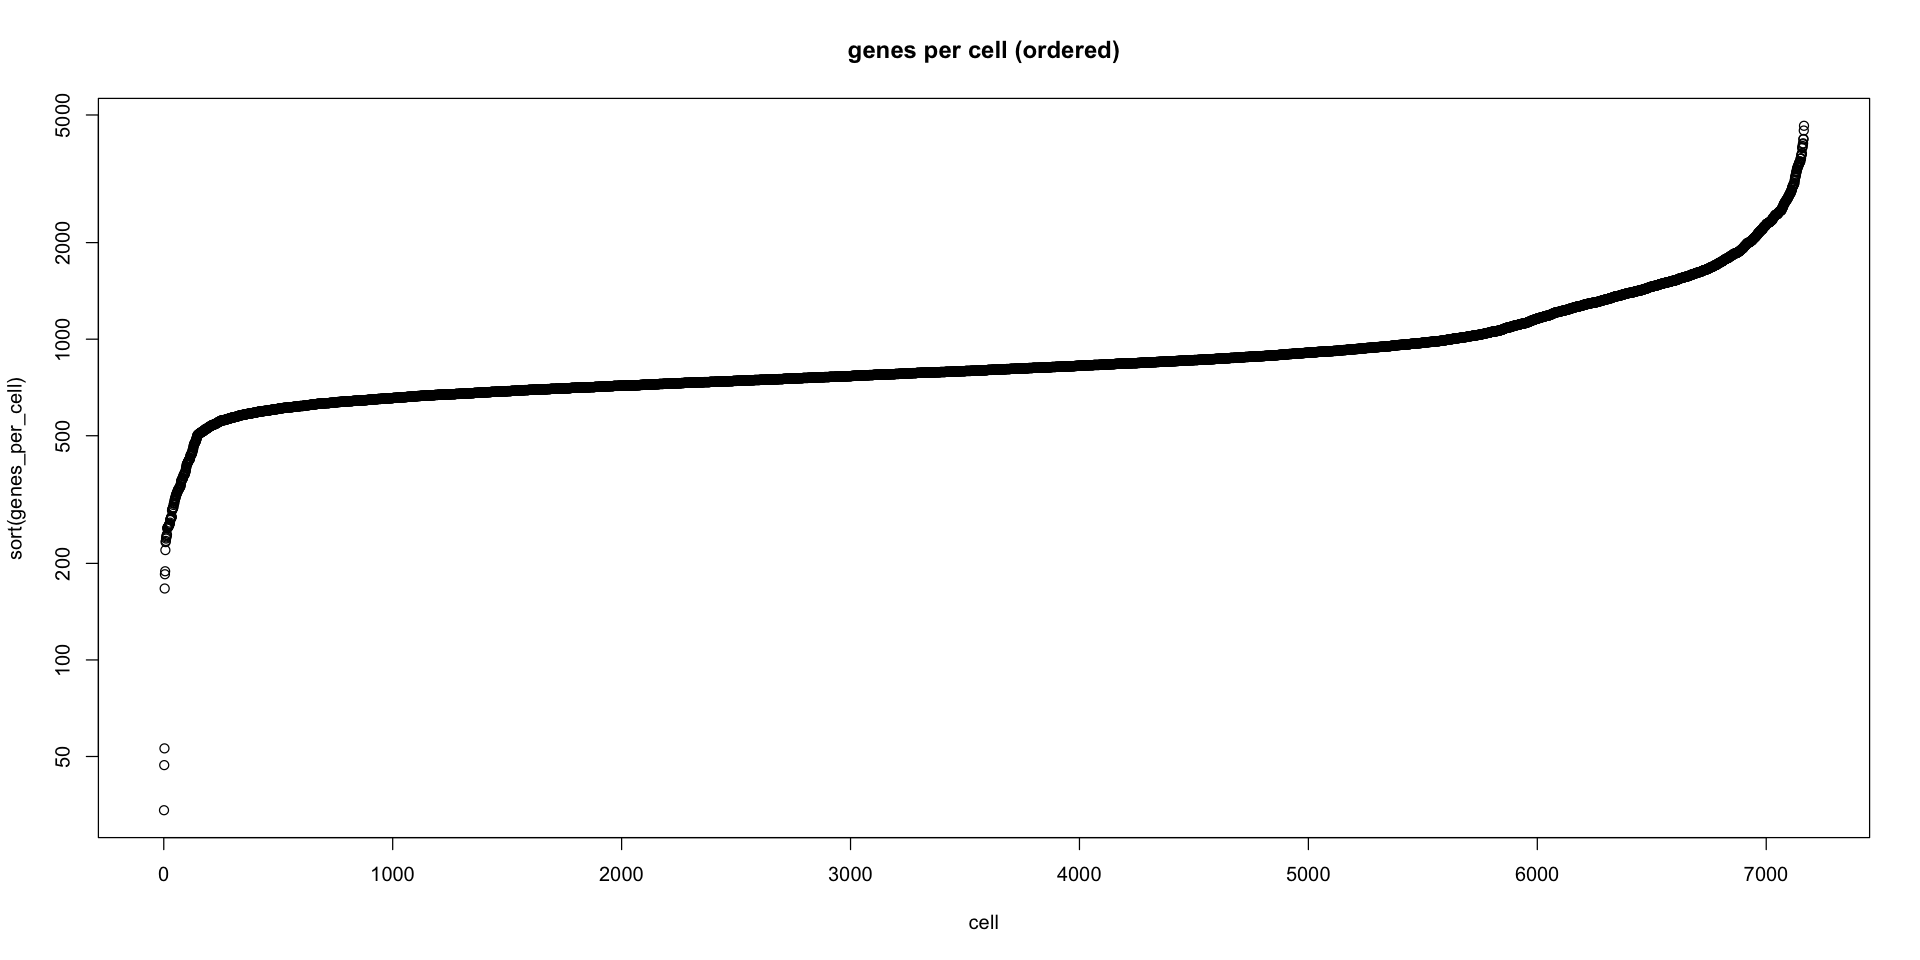

In [14]:
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')

In [15]:
dim(counts)

[1] 63568  7165

In [16]:
seurat<-CreateSeuratObject(counts = counts, min.cells = 3, min.features = 350, project = "FLU")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [17]:
dim(seurat)

[1] 16977  7092

In [18]:
seurat@assays$RNA@counts[1:30, 1:30]

   [[ suppressing 30 column names ‘AAACCTGAGATCGGGT-1’, ‘AAACCTGAGCCAGAAC-1’, ‘AAACCTGAGCGTGAAC-1’ ... ]]



30 x 30 sparse Matrix of class "dgCMatrix"
                                                                             
WASH7P         . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
CICP27         . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
AL627309.1     . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
AP006222.2     . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP4-669L17.10  . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP5-857K21.4   . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
MTND1P23       . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
MTND2P28       . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
hsa-mir-6723   . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
MTATP6P1       . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP11-206L10.3  . . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . .
RP11-206L10.2  . . . 

In [19]:
# The number of genes and UMIs (nGene and nUMI) are automatically calculated
# for every object by Seurat.  For non-UMI data, nUMI represents the sum of
# the non-normalized values within a cell We calculate the percentage of
# mitochondrial genes here and store it in percent.mito using AddMetaData.
# We use object@raw.data since this represents non-transformed and
# non-log-normalized counts The % of UMI mapping to MT-genes is a common
# scRNA-seq QC metric.
mito.genes <- grep(pattern = "^MT-", x = rownames(x = seurat@assays$RNA@data), value = TRUE)
percent.mito <- Matrix::colSums(seurat@assays$RNA@data[mito.genes, ])/Matrix::colSums(seurat@assays$RNA@data)

# AddMetaData adds columns to object@meta.data, and is a great place to stash QC stats.
# This also allows us to plot the metadata values using the Seurat's VlnPlot().
head(seurat@meta.data) # Before adding

orig.ident nCount_RNA nFeature_RNA
AAACCTGAGATCGGGT-1 FLU        1795        722        
AAACCTGAGCCAGAAC-1 FLU        1099        541        
AAACCTGAGCGTGAAC-1 FLU        2802       1065        
AAACCTGCAAGCCGCT-1 FLU        1194        524        
AAACCTGCACTTGGAT-1 FLU        4295       1489        
AAACCTGCAGACGCAA-1 FLU        2211        840

orig.ident nCount_RNA nFeature_RNA percent.mito
AAACCTGAGATCGGGT-1 FLU        1795        722         0.01727019  
AAACCTGAGCCAGAAC-1 FLU        1099        541         0.04367607  
AAACCTGAGCGTGAAC-1 FLU        2802       1065         0.04925054  
AAACCTGCAAGCCGCT-1 FLU        1194        524         0.10804020  
AAACCTGCACTTGGAT-1 FLU        4295       1489         0.02048894  
AAACCTGCAGACGCAA-1 FLU        2211        840         0.03889643

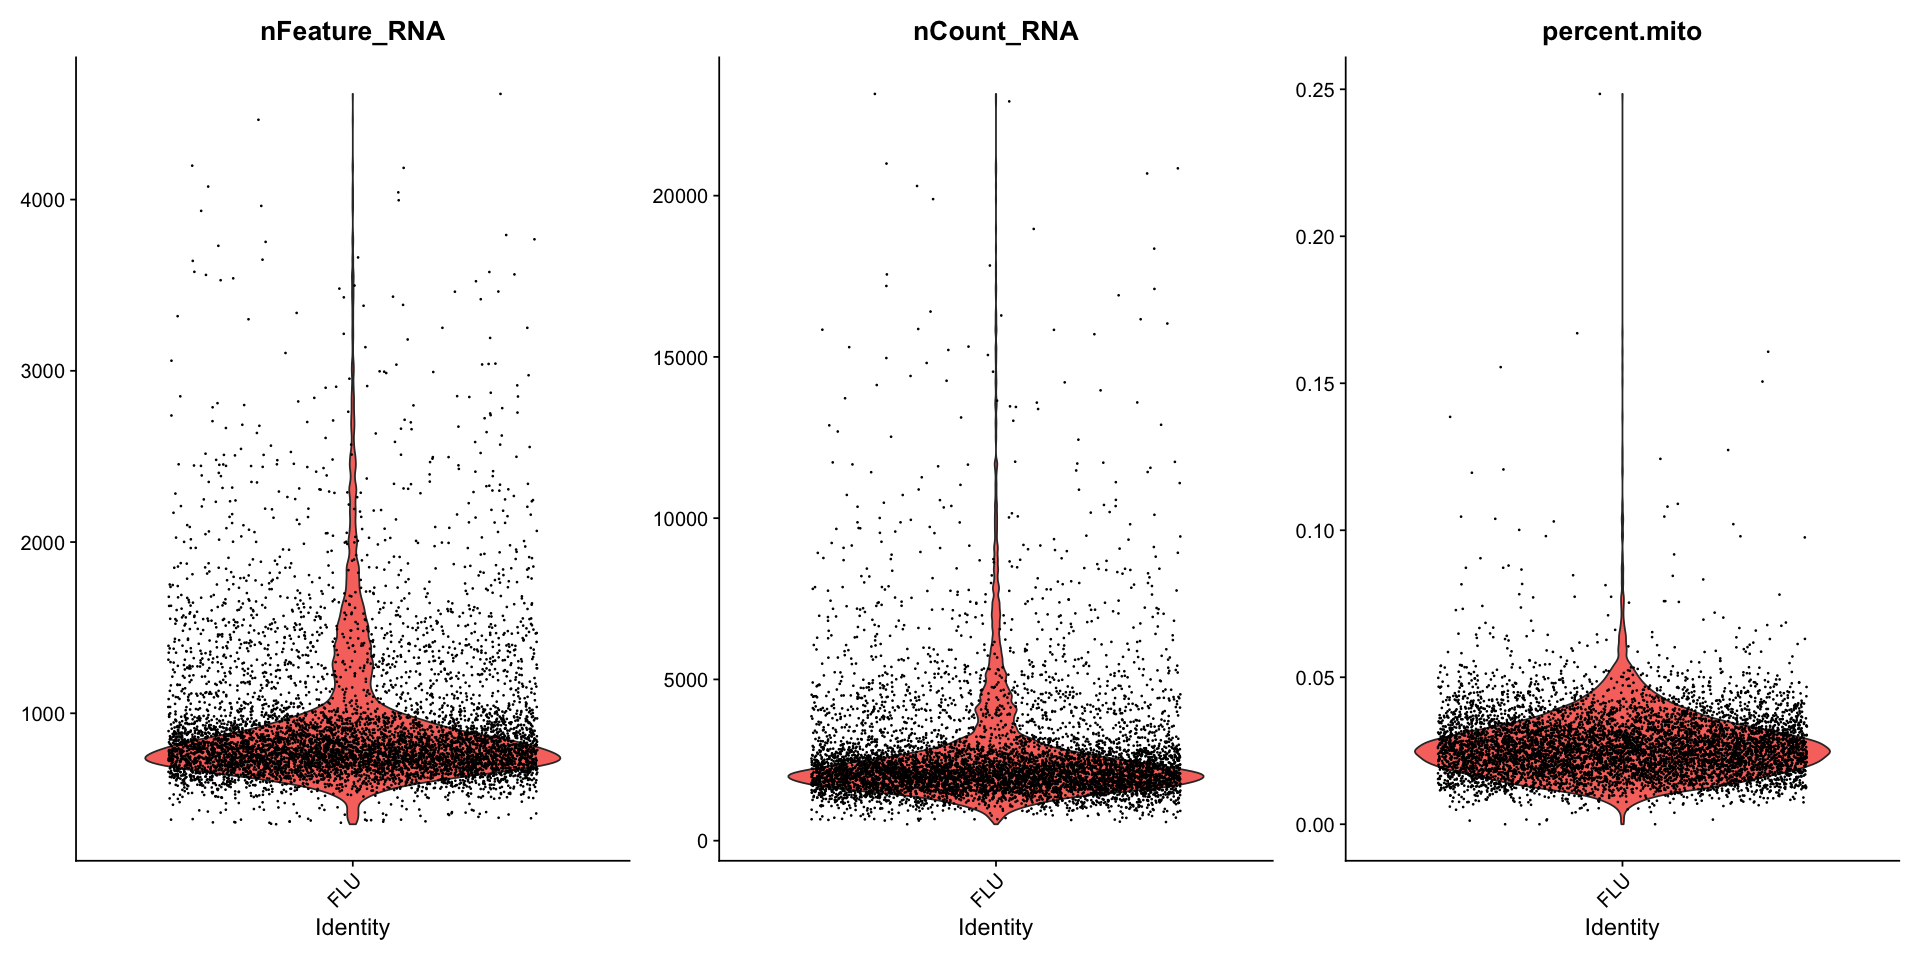

In [20]:
seurat <- AddMetaData(object = seurat, percent.mito, col.name = "percent.mito")
head(seurat@meta.data) # After adding
VlnPlot(object = seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"))

In [21]:
str(seurat)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:6609320] 71 95 103 109 110 125 140 165 176 190 ...
  .. .. .. .. .. ..@ p       : int [1:7093] 0 722 1263 2328 2852 4341 5181 5790 6478 7160 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 16977 7092
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:16977] "WASH7P" "CICP27" "AL627309.1" "AP006222.2" ...
  .. .. .. .. .. .. ..$ : chr [1:7092] "AAACCTGAGATCGGGT-1" "AAACCTGAGCCAGAAC-1" "AAACCTGAGCGTGAAC-1" "AAACCTGCAAGCCGCT-1" ...
  .. .. .. .. .. ..@ x       : num [1:6609320] 1 1 1 1 1 2 1 1 1 1 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:6609320] 71 95 103 109 110 12

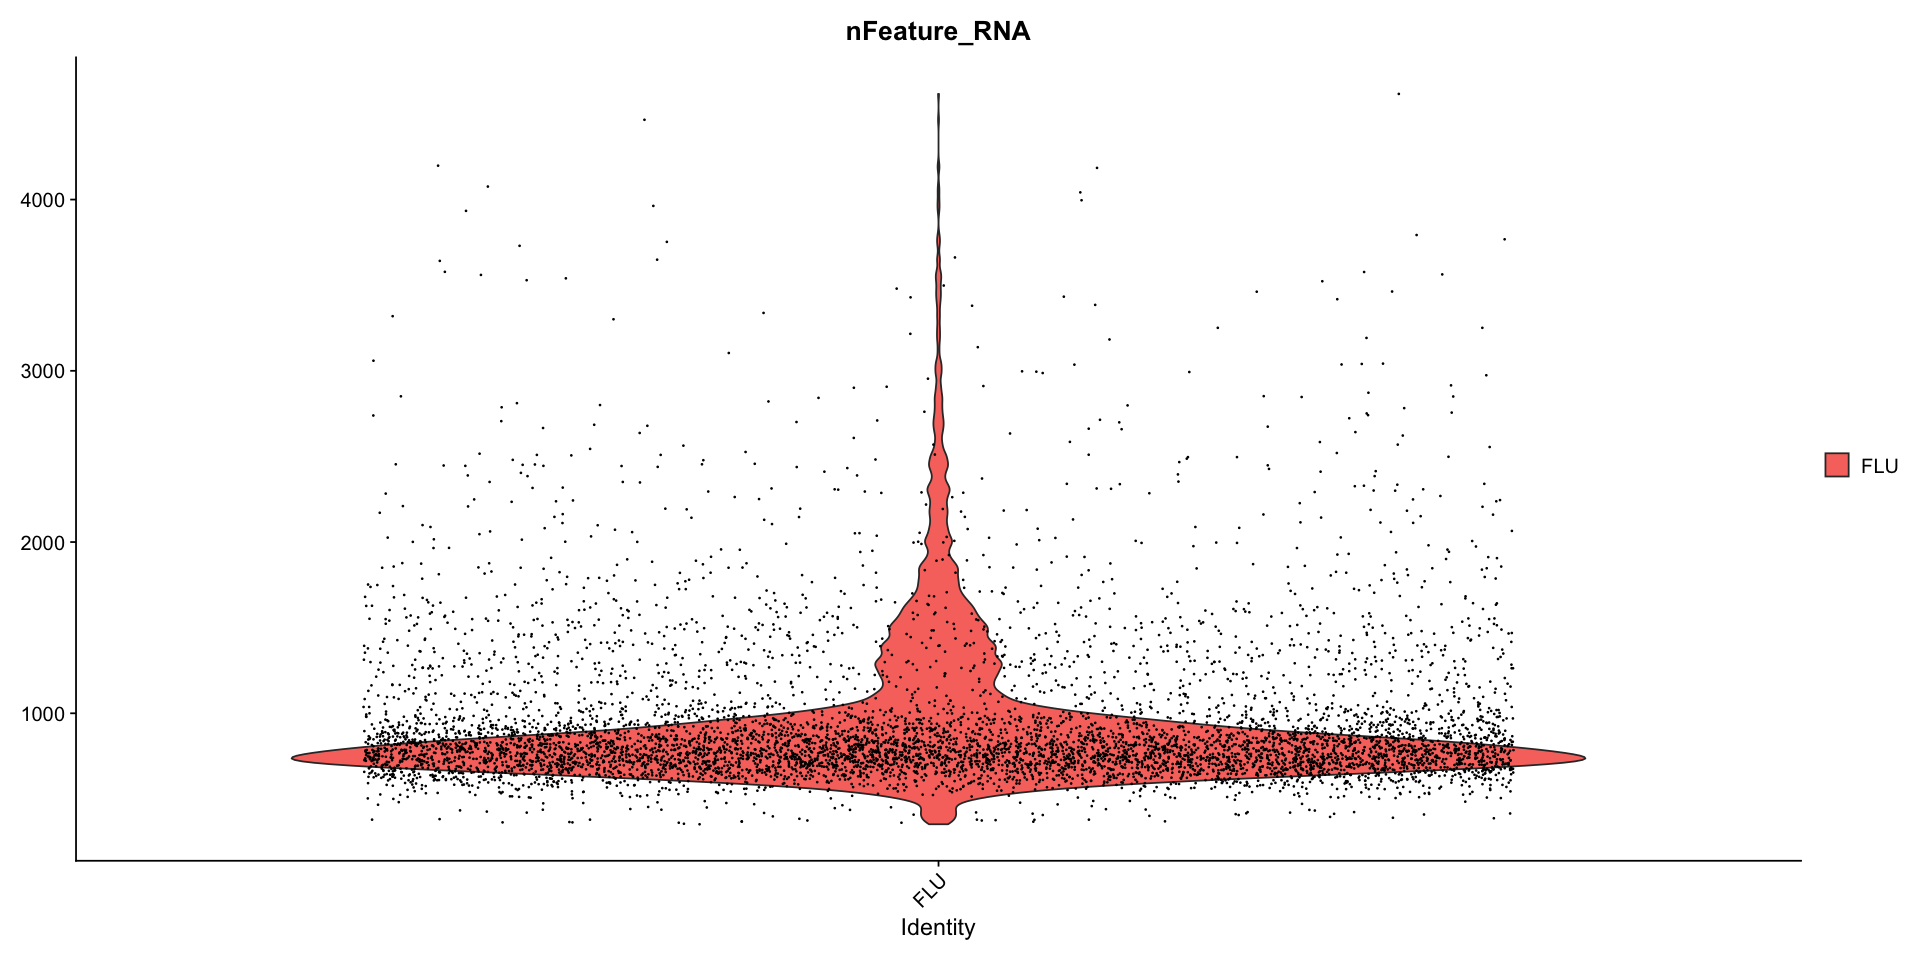

In [22]:
VlnPlot(object = seurat, features = c("nFeature_RNA"), group.by = c('orig.ident'))

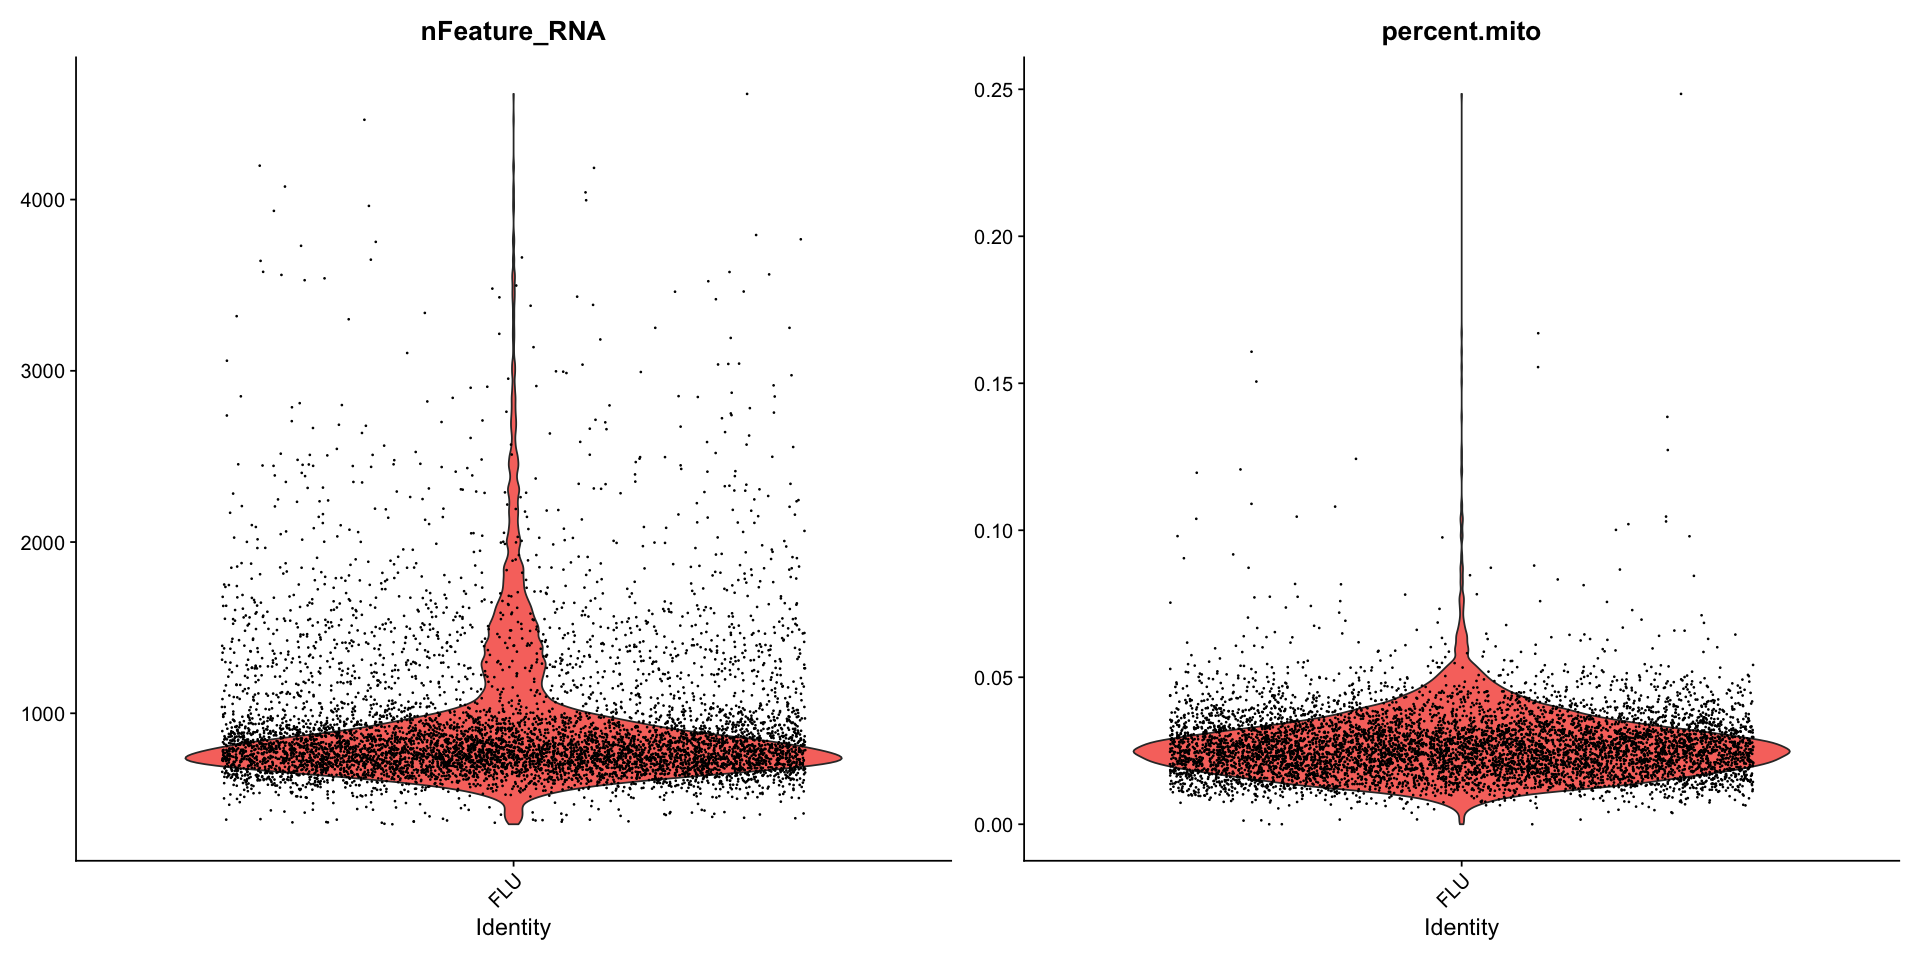

In [23]:
#VlnPlot(object = seurat, features = c("nFeature_RNA","percent.mito","n.exp.hkgenes"), ncol = 3)
VlnPlot(object = seurat, features = c("nFeature_RNA","percent.mito"), ncol = 2)

In [24]:
#seurat <- subset(seurat, subset = nFeature_RNA > 350 & nFeature_RNA < 4000 & percent.mito < 0.15 & n.exp.hkgenes > 55)

After demultiplexing cells into samples, Seurat (v3.1.5, R v3.6.3) was used to perform quality control filtering of cells. In total, we captured 255,731 cells prior to filtering (range of cells recovered per capture: min. = 5,534, max. = 10,805).


Cells were considered “high-quality” and retained for downstream analysis if they had: 
1) a “singlet” status called by souporcell, 
2) between 200 – 2500 genes detected (nFeature_RNA), and 
3) a mitochondrial reads percentage < 10%, leaving 236,993 cells (n = 19,248 genes).

In [25]:
seurat <- subset(seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mito < 0.1)

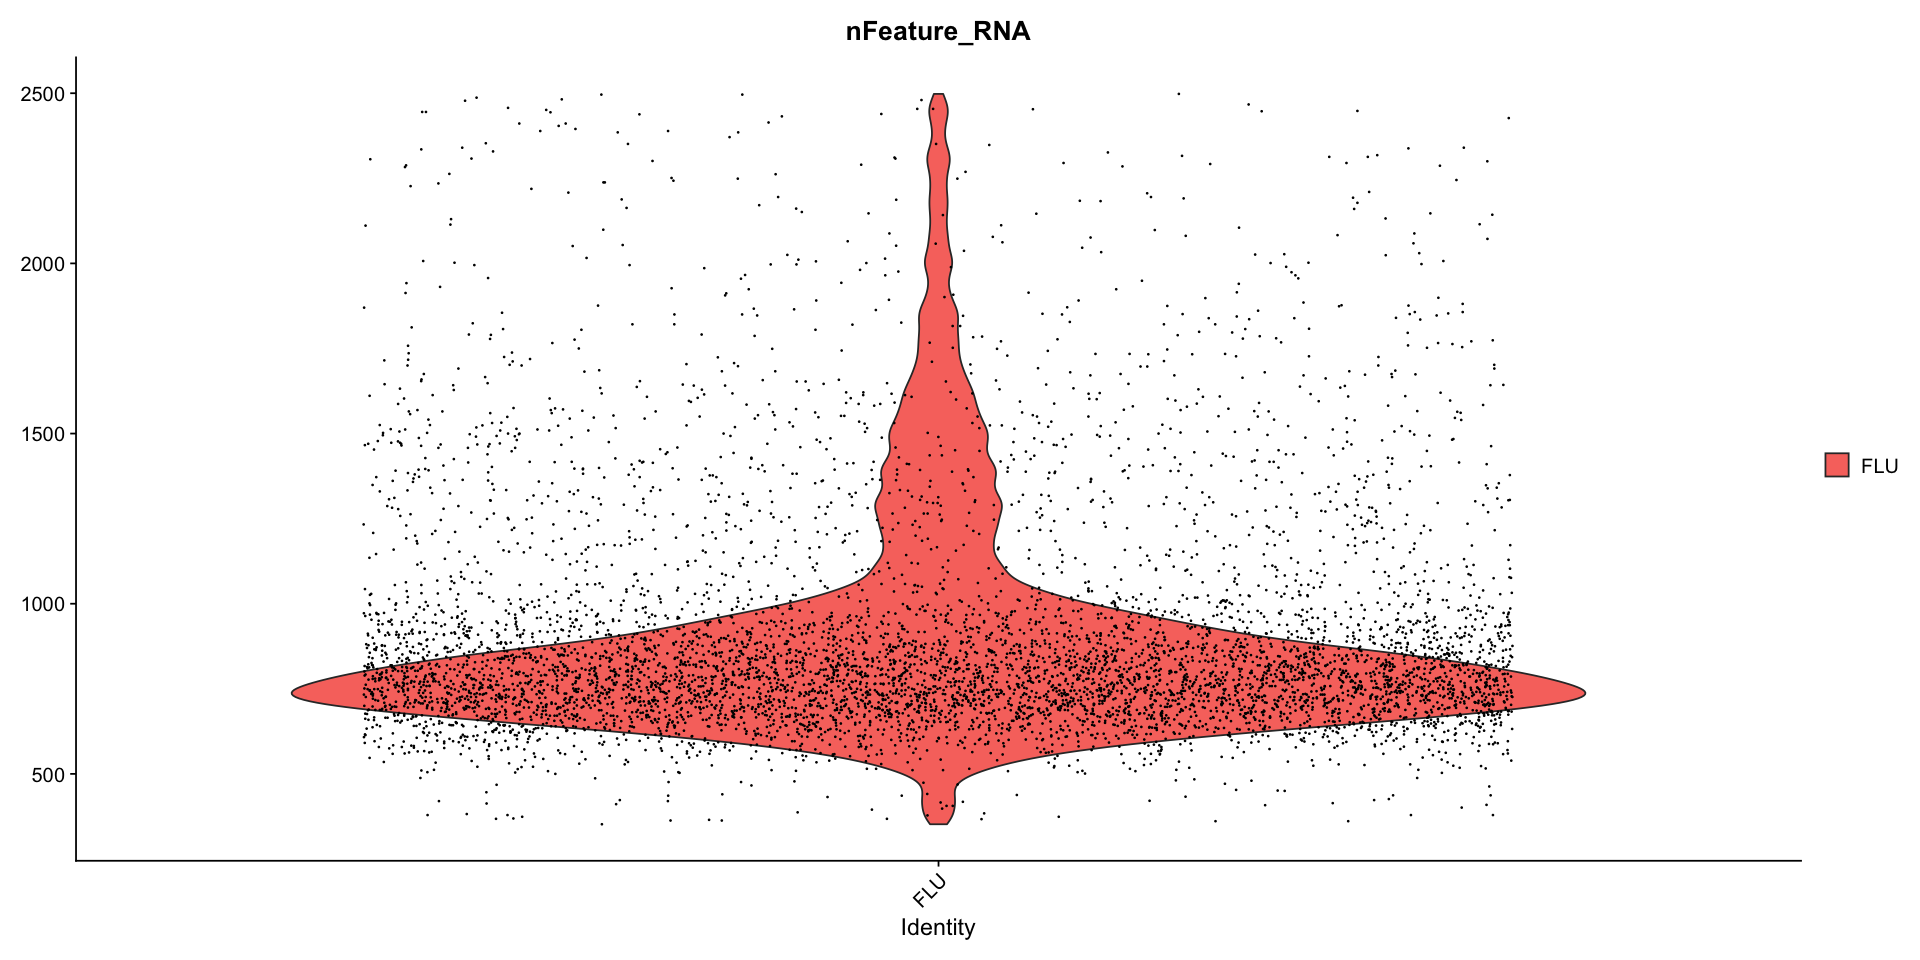

In [26]:
VlnPlot(object = seurat, features = c("nFeature_RNA"), group.by = c('orig.ident'))

In [27]:
seurat@assays$RNA@counts[1:30, 1:30]

   [[ suppressing 30 column names ‘AAACCTGAGATCGGGT-1’, ‘AAACCTGAGCCAGAAC-1’, ‘AAACCTGAGCGTGAAC-1’ ... ]]



30 x 30 sparse Matrix of class "dgCMatrix"
                                                                             
WASH7P         . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
CICP27         . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
AL627309.1     . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
AP006222.2     . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP4-669L17.10  . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP5-857K21.4   . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
MTND1P23       . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
MTND2P28       . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
hsa-mir-6723   . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
MTATP6P1       . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP11-206L10.3  . . .  . . . . . . . . . . . . . . . . .  . . .  . . . . . . .
RP11-206L10.2  . . . 

In [28]:
seurat <- NormalizeData(object = seurat, normalization.method = "LogNormalize", scale.factor = 1e4)

In [29]:
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge = 0, ynudge = 0)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


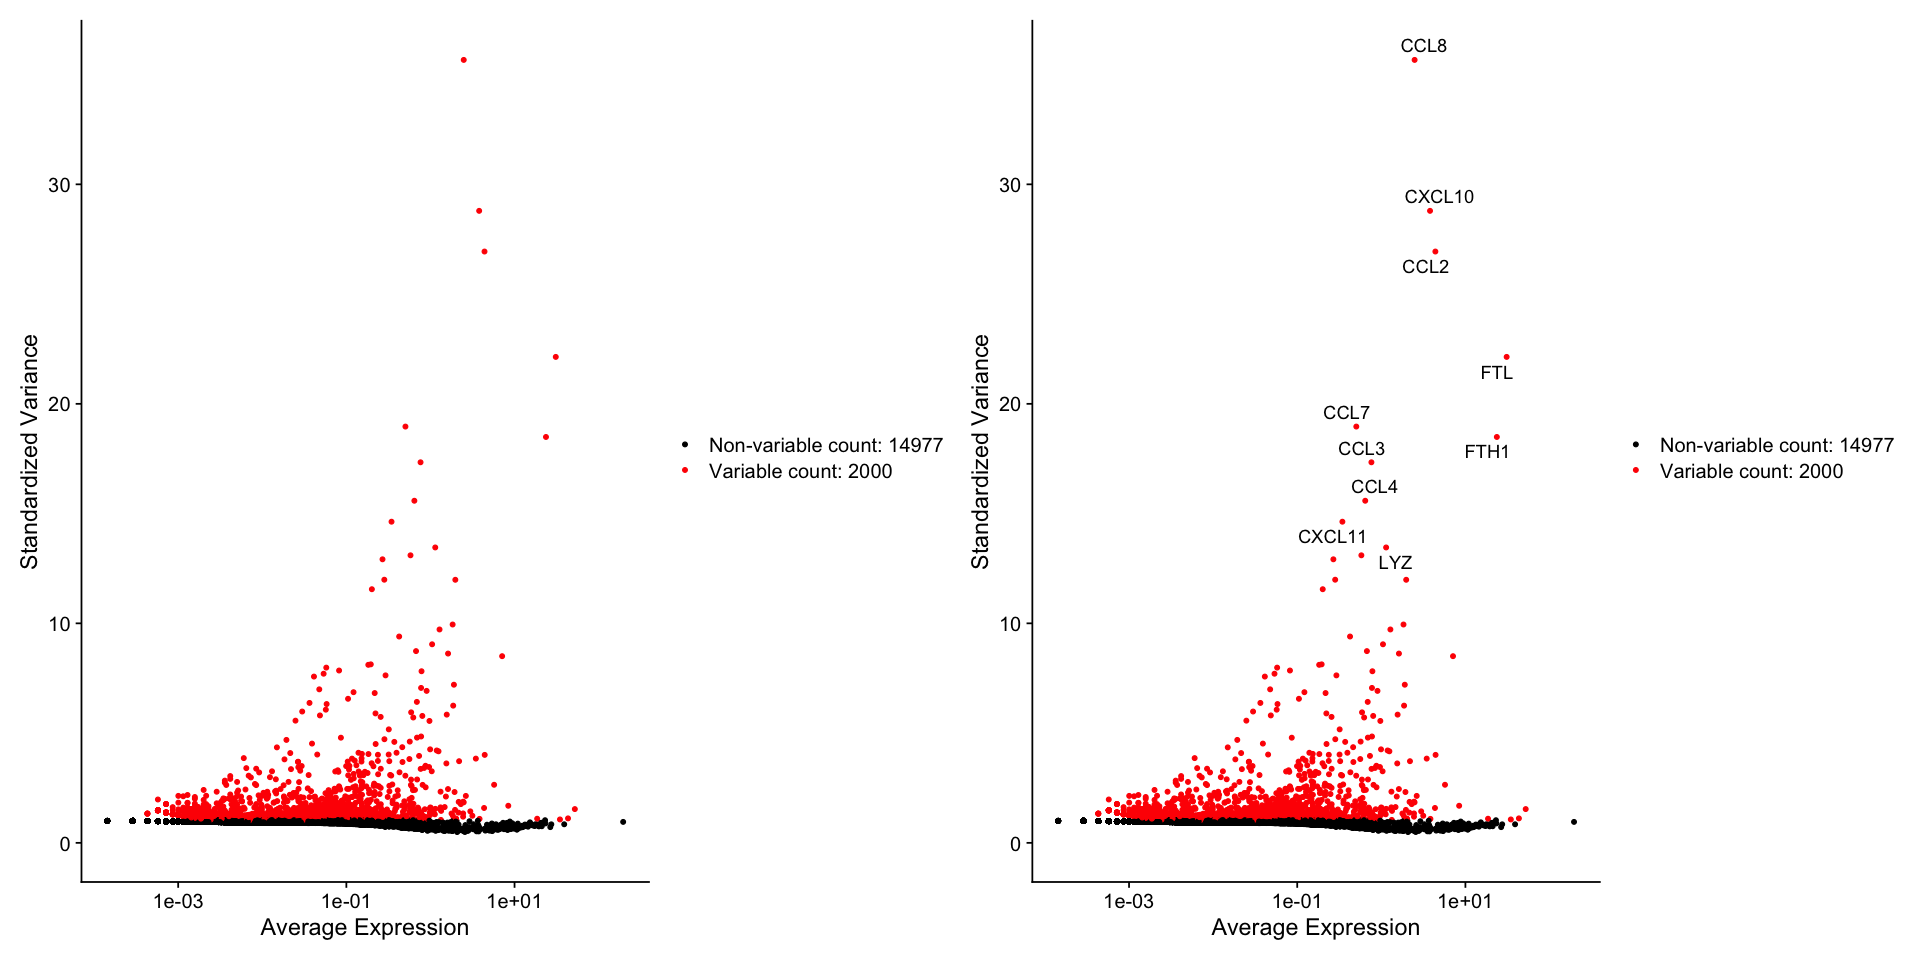

In [30]:
plot1 + plot2

In [31]:
dim(seurat)

[1] 16977  6968

In [32]:
## Read in a list of cell cycle markers, from Tirosh et al, 2015.
## We can segregate this list into markers of G2/M phase and markers of S phase.
#cc.genes <- readLines("data/resources/regev_lab_cell_cycle_genes.txt")
#s.genes <- cc.genes[1:43]
#g2m.genes <- cc.genes[44:97]
#seurat <- CellCycleScoring(seurat, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [33]:
filtered_barcode_count=length(colnames(seurat@assays$RNA@data))
filtered_barcode_count

[1] 6968

In [34]:
head(colnames(seurat@assays$RNA@data))

[1] "AAACCTGAGATCGGGT-1" "AAACCTGAGCCAGAAC-1" "AAACCTGAGCGTGAAC-1"
[4] "AAACCTGCACTTGGAT-1" "AAACCTGCAGACGCAA-1" "AAACCTGGTAGAGCTG-1"

In [35]:
original_barcode_count - filtered_barcode_count

[1] 197

Combine this list of barcodes with souporcell's `clusters.tsv` in linking selection of bam reads.

In [36]:
library("scPred")
library("Seurat")
library("magrittr")

In [37]:
reference <- scPred::pbmc_1

In [38]:
reference <- reference %>% 
  NormalizeData() %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA() %>% 
  RunUMAP(dims = 1:30)

Centering and scaling data matrix

PC_ 1 
Positive:  MALAT1, RPS12, RPL13, RPS18, RPS4X, LTB, IL32, IL7R, EEF1A1, RPL10 
	   NOSIP, RPS2, CD2, CD7, CCR7, CD27, CD69, MAL, TSHZ2, ITM2A 
	   MYC, TRAT1, CD247, FHIT, GZMM, SH3YL1, TXK, AQP3, TESPA1, PIM1 
Negative:  CST3, FCN1, LYZ, LST1, CSTA, S100A9, SERPINA1, CD68, AIF1, SPI1 
	   CFD, MNDA, S100A8, VCAN, TYROBP, KLF4, CLEC7A, CTSS, PSAP, S100A12 
	   FCER1G, MS4A6A, TYMP, FTL, NCF2, FGL2, CYBB, IFI30, IGSF6, CD14 
PC_ 2 
Positive:  NKG7, CST7, GNLY, GZMA, GZMB, FGFBP2, PRF1, CCL5, B2M, CTSW 
	   KLRD1, GZMH, KLRF1, CCL4, HOPX, SPON2, CLIC3, CMC1, KLRB1, GZMM 
	   FCGR3A, IFITM2, TMSB4X, EFHD2, MATK, ITGB2, MYO1F, PFN1, SRGN, CD247 
Negative:  RPL13, RPS12, RPS18, LTB, RPS2, EEF1A1, RPL10, RPLP1, RPS4X, TPT1 
	   MS4A1, CD79A, HLA-DRA, BANK1, MEF2C, LINC00926, HLA-DQB1, HLA-DQA1, VPREB3, CD79B 
	   NCF1, IL7R, CCR7, BIRC3, TNFRSF13C, MARCH1, RALGPS2, TCL1A, HLA-DMB, CD22 
PC_ 3 
Positive:  CD79A, MS4A1, CD79B, HLA-DQA1, CD74, BANK1, HL

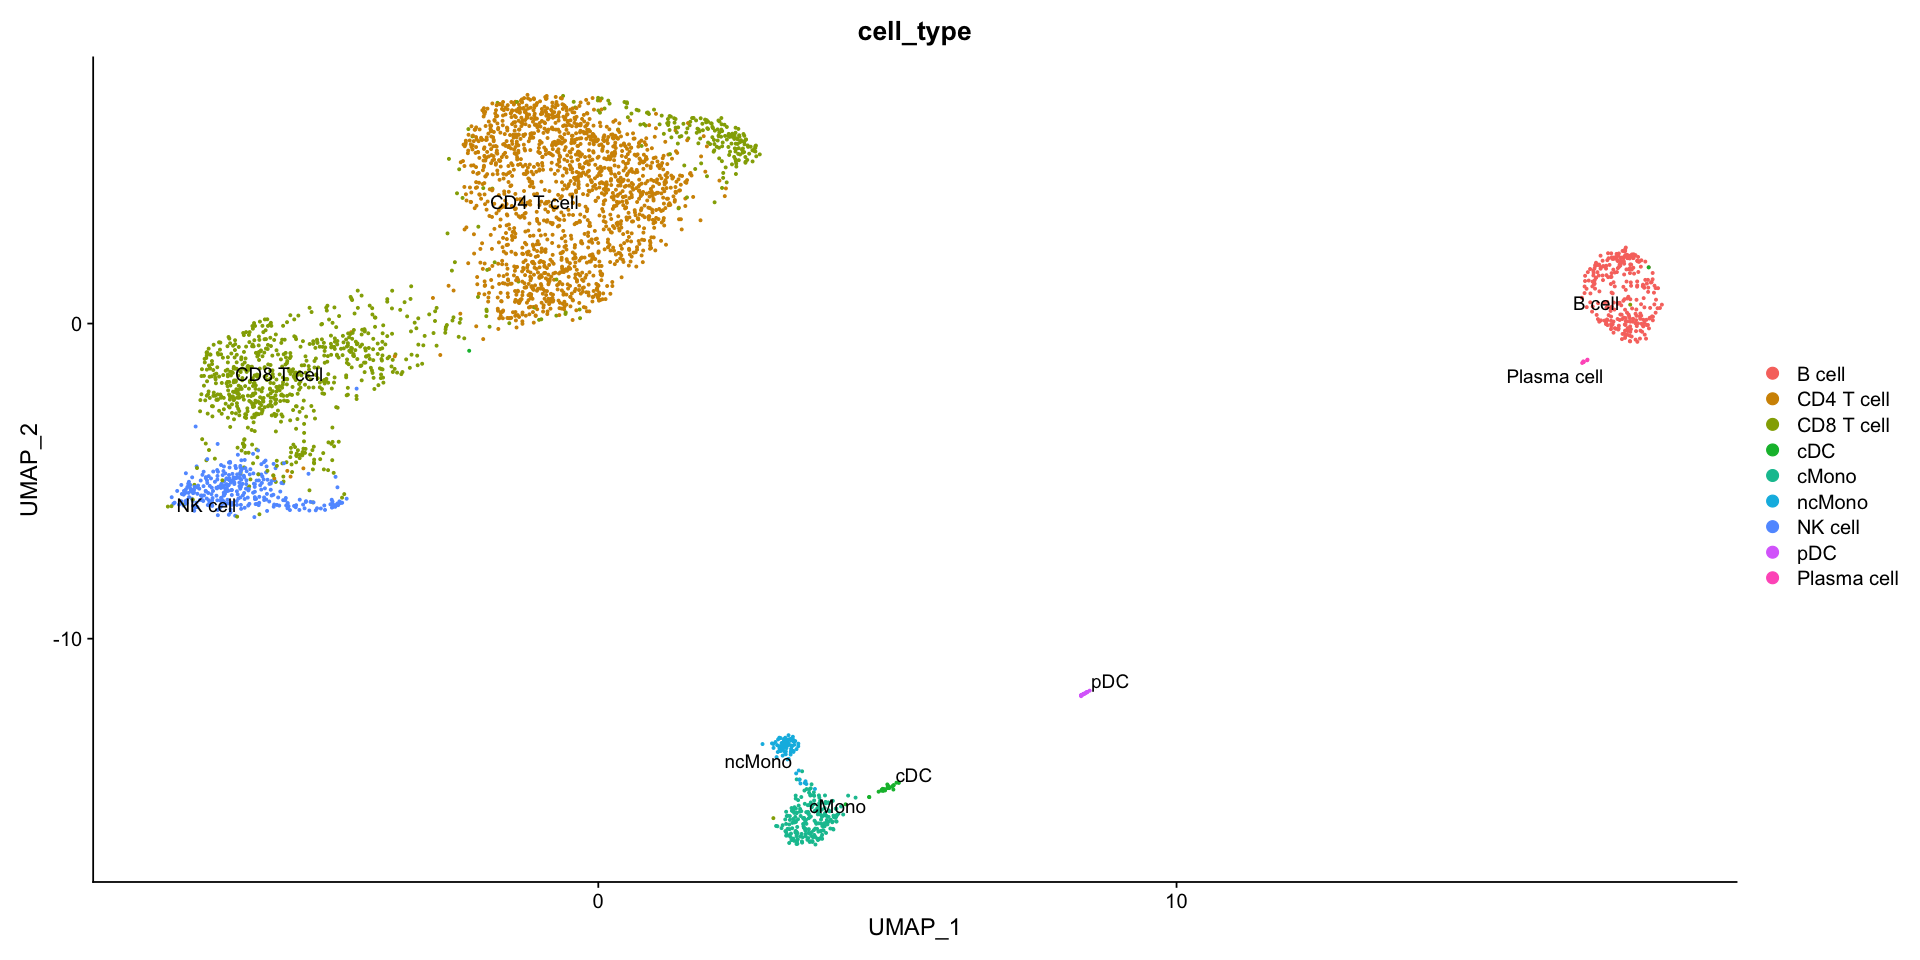

In [39]:
DimPlot(reference, group.by = "cell_type", label = TRUE, repel = TRUE)

In [40]:
reference <- getFeatureSpace(reference, "cell_type")

●  Extracting feature space for each cell type...
DONE!


In [41]:
reference <- trainModel(reference)

●  Training models for each cell type...


Loading required package: ggplot2

Loading required package: lattice



maximum number of iterations reached 0.0001163544 -0.0001154305DONE!


In [42]:
get_probabilities(reference) %>% head()

CD8 T cell CD4 T cell   cMono        B cell      
CCACGGACATGCTGGC-1 0.99997400 3.986948e-06 3.429930e-05 1.895677e-04
GATTCAGGTCTCCACT-1 0.04042862 9.889574e-01 1.067423e-06 4.731890e-05
TGTATTCTCTATGTGG-1 0.03911453 7.548134e-03 7.249458e-01 1.130582e-02
GTCTCGTGTTCACGGC-1 0.03818003 5.260064e-03 6.232676e-02 8.985316e-01
TATCAGGCACCAACCG-1 0.99975425 2.711294e-06 6.725367e-06 3.310682e-05
TTTGCGCAGTAAGTAC-1 0.00813470 9.933063e-01 1.465473e-07 8.092728e-05
                   NK cell      pDC          ncMono       cDC         
CCACGGACATGCTGGC-1 3.086312e-06 1.838937e-05 9.126555e-10 8.811149e-05
GATTCAGGTCTCCACT-1 1.172672e-05 5.054285e-06 1.752136e-08 3.084253e-06
TGTATTCTCTATGTGG-1 8.314200e-03 2.649234e-02 2.539761e-01 4.782914e-02
GTCTCGTGTTCACGGC-1 9.004368e-03 5.195012e-03 4.323785e-03 6.153321e-03
TATCAGGCACCAACCG-1 4.771576e-04 1.677773e-05 4.027229e-09 2.176531e-05
TTTGCGCAGTAAGTAC-1 2.445414e-04 4.071722e-06 2.025713e-12 4.537904e-08
                   Plasma cell 
CCACGGACATGCTGGC-1 0.0004788954
GATTCAGGTCTCCACT-1 0.0003292191
TGTATTCTCTATGTGG-1 0.0030142849
GTCTCGTGTTCACGGC-1 0.0019860613
TATCAGGCACCAACCG-1 0.0004192118
TTTGCGCAGTAAGTAC-1 0.0001529051

In [43]:
get_scpred(reference)

'scPred' object
✔  Prediction variable = cell_type 
✔  Discriminant features per cell type
✔  Training model(s)
Summary

|Cell type   |    n| Features|Method    |   ROC|  Sens|  Spec|
|:-----------|----:|--------:|:---------|-----:|-----:|-----:|
|B cell      |  280|       50|svmRadial | 1.000| 0.964| 1.000|
|CD4 T cell  | 1620|       50|svmRadial | 0.997| 0.971| 0.975|
|CD8 T cell  |  945|       50|svmRadial | 0.985| 0.902| 0.978|
|cDC         |   26|       50|svmRadial | 0.995| 0.547| 1.000|
|cMono       |  212|       50|svmRadial | 0.994| 0.958| 0.970|
|ncMono      |   79|       50|svmRadial | 0.998| 0.570| 1.000|
|NK cell     |  312|       50|svmRadial | 0.999| 0.936| 0.996|
|pDC         |   20|       50|svmRadial | 1.000| 0.700| 1.000|
|Plasma cell |    6|       50|svmRadial | 1.000| 0.800| 1.000|

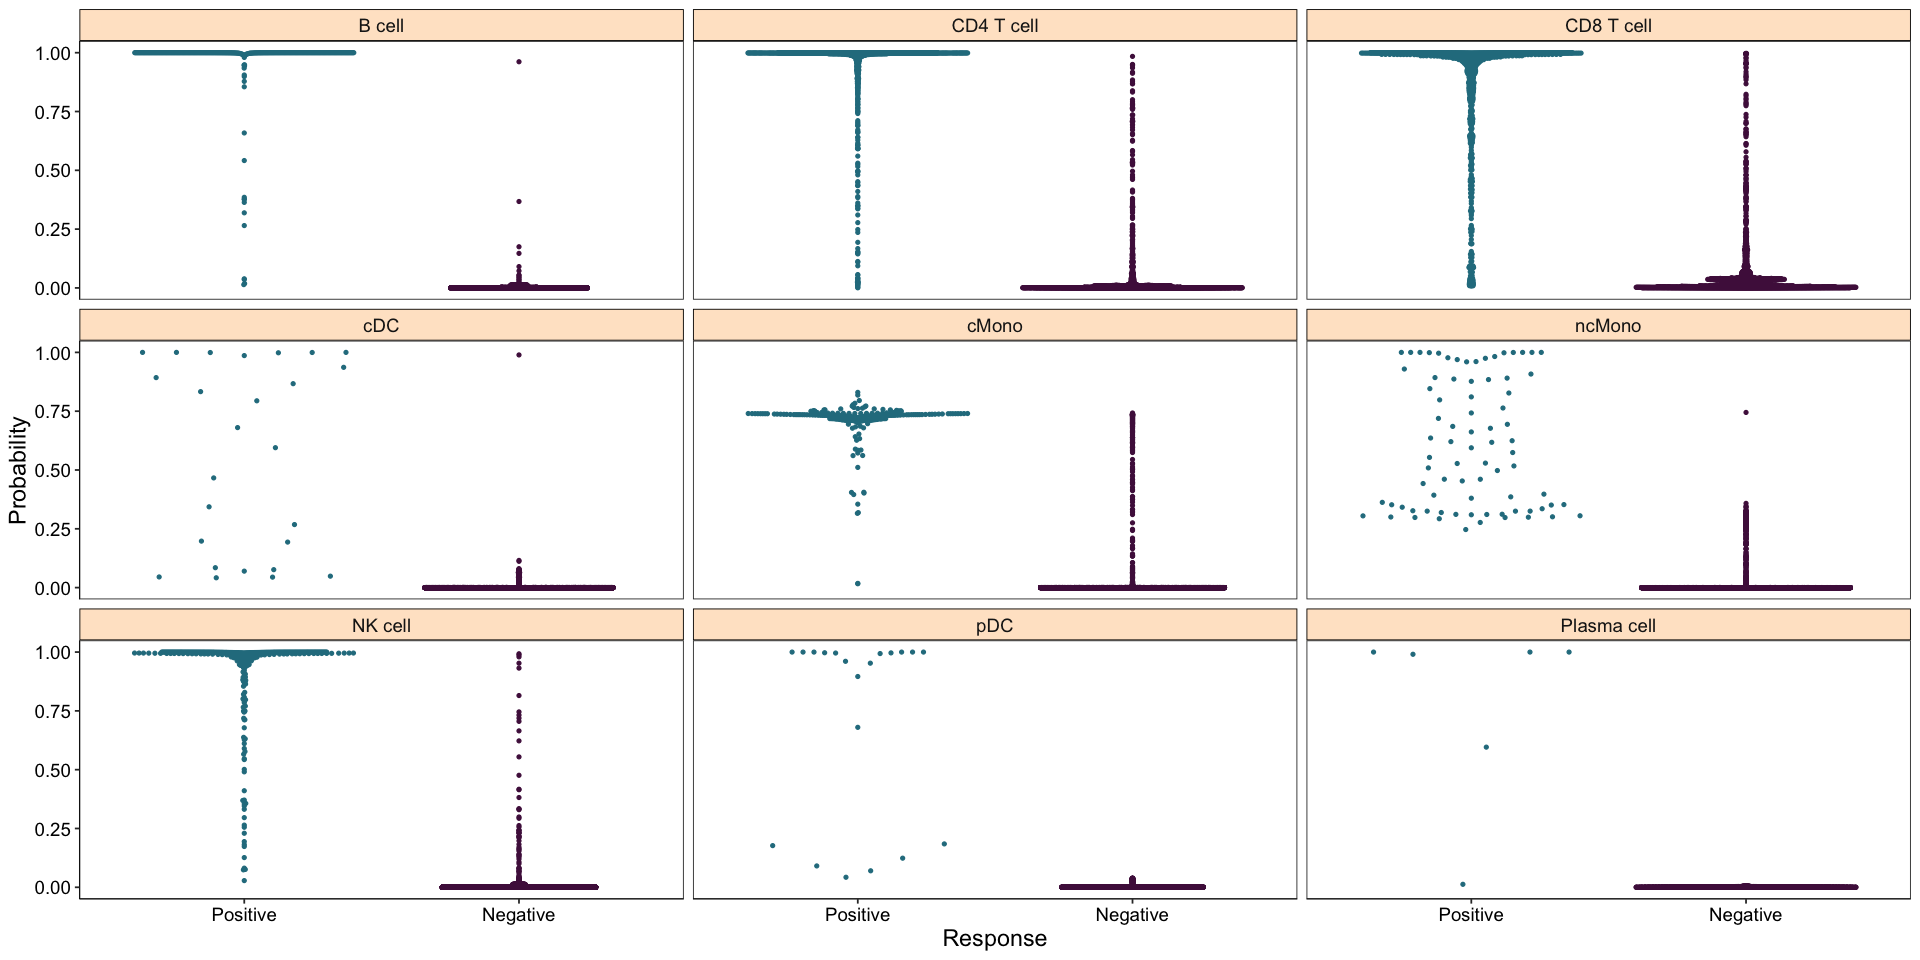

In [44]:
plot_probabilities(reference)

In [45]:
reference <- trainModel(reference, model = "mda", reclassify = c("cMono", "ncMono"))

●  Training models for each cell type...
DONE!


In [46]:
get_scpred(reference)

'scPred' object
✔  Prediction variable = cell_type 
✔  Discriminant features per cell type
✔  Training model(s)
Summary

|Cell type   |    n| Features|Method    |   ROC|  Sens|  Spec|
|:-----------|----:|--------:|:---------|-----:|-----:|-----:|
|B cell      |  280|       50|svmRadial | 1.000| 0.964| 1.000|
|CD4 T cell  | 1620|       50|svmRadial | 0.997| 0.971| 0.975|
|CD8 T cell  |  945|       50|svmRadial | 0.985| 0.902| 0.978|
|cDC         |   26|       50|svmRadial | 0.995| 0.547| 1.000|
|cMono       |  212|       50|mda       | 0.999| 0.990| 0.997|
|ncMono      |   79|       50|mda       | 1.000| 0.949| 0.999|
|NK cell     |  312|       50|svmRadial | 0.999| 0.936| 0.996|
|pDC         |   20|       50|svmRadial | 1.000| 0.700| 1.000|
|Plasma cell |    6|       50|svmRadial | 1.000| 0.800| 1.000|

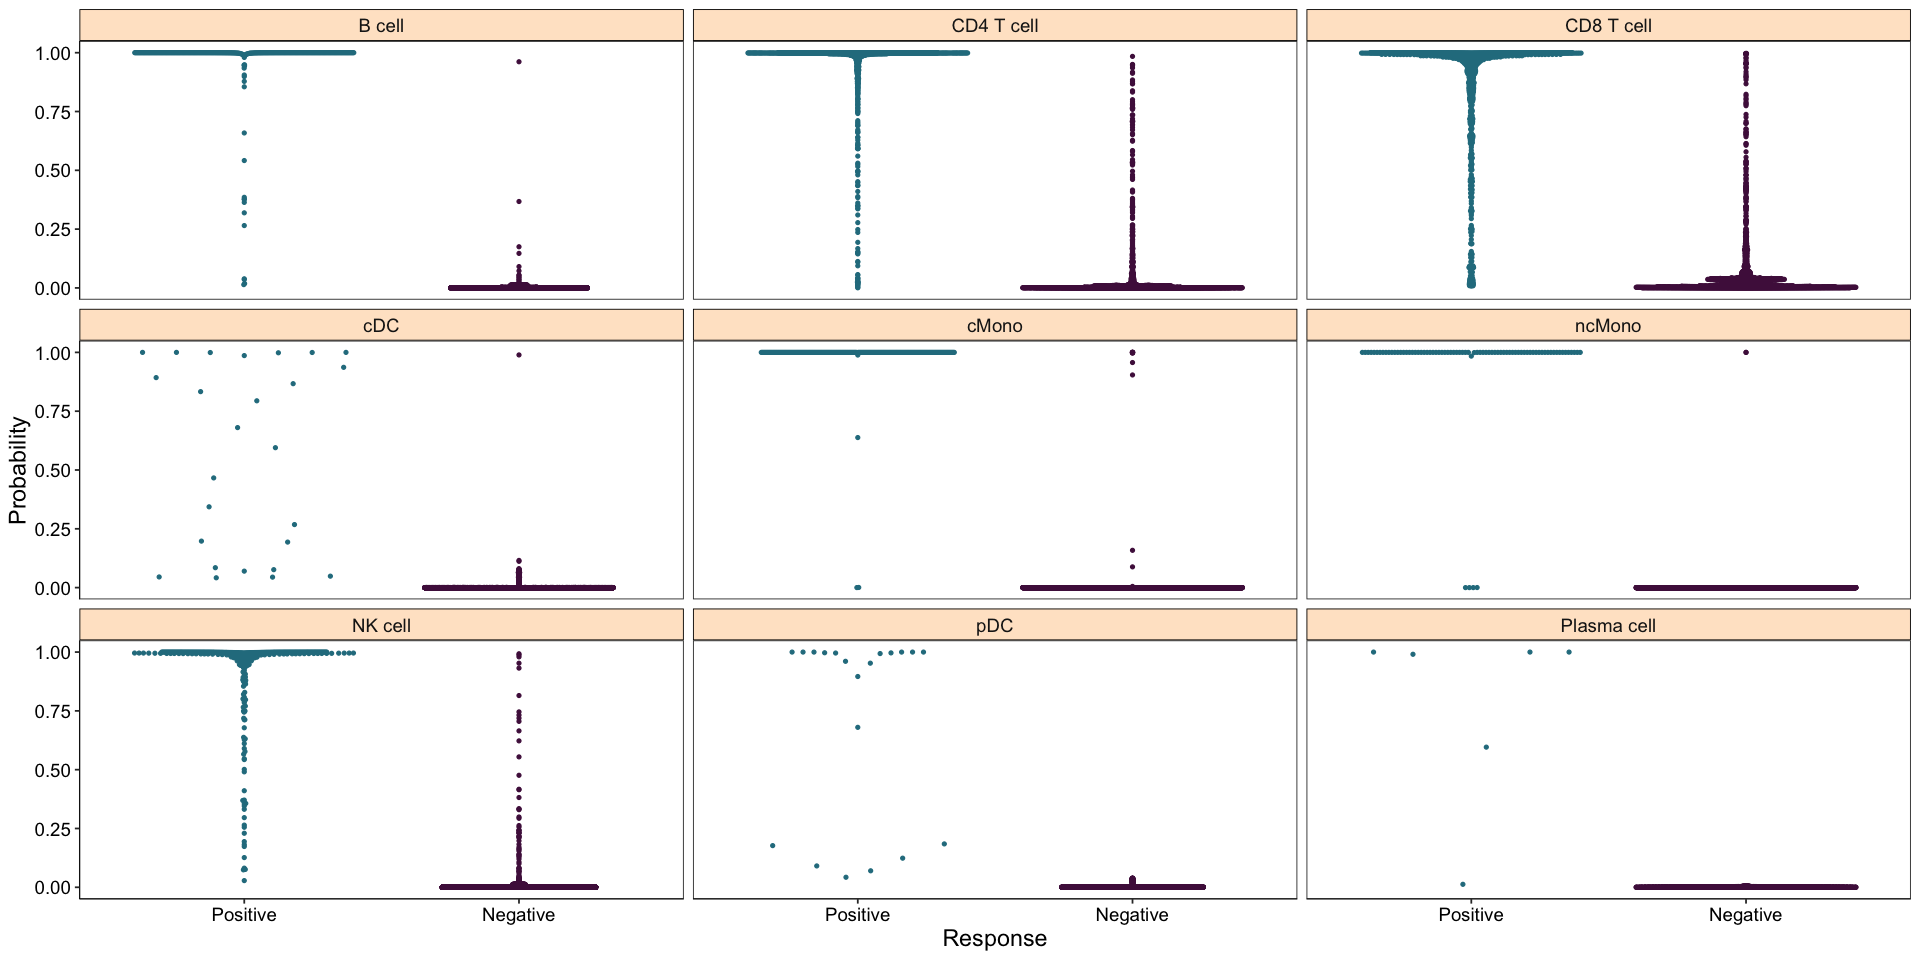

In [47]:
plot_probabilities(reference)

In [48]:
query <- scPredict(seurat, reference)

●  Matching reference with new dataset...
	 ─ 2000 features present in reference loadings
	 ─ 1763 features shared between reference and new dataset
	 ─ 88.15% of features in the reference are present in new dataset
●  Aligning new data to reference...


Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



●  Classifying cells...
DONE!


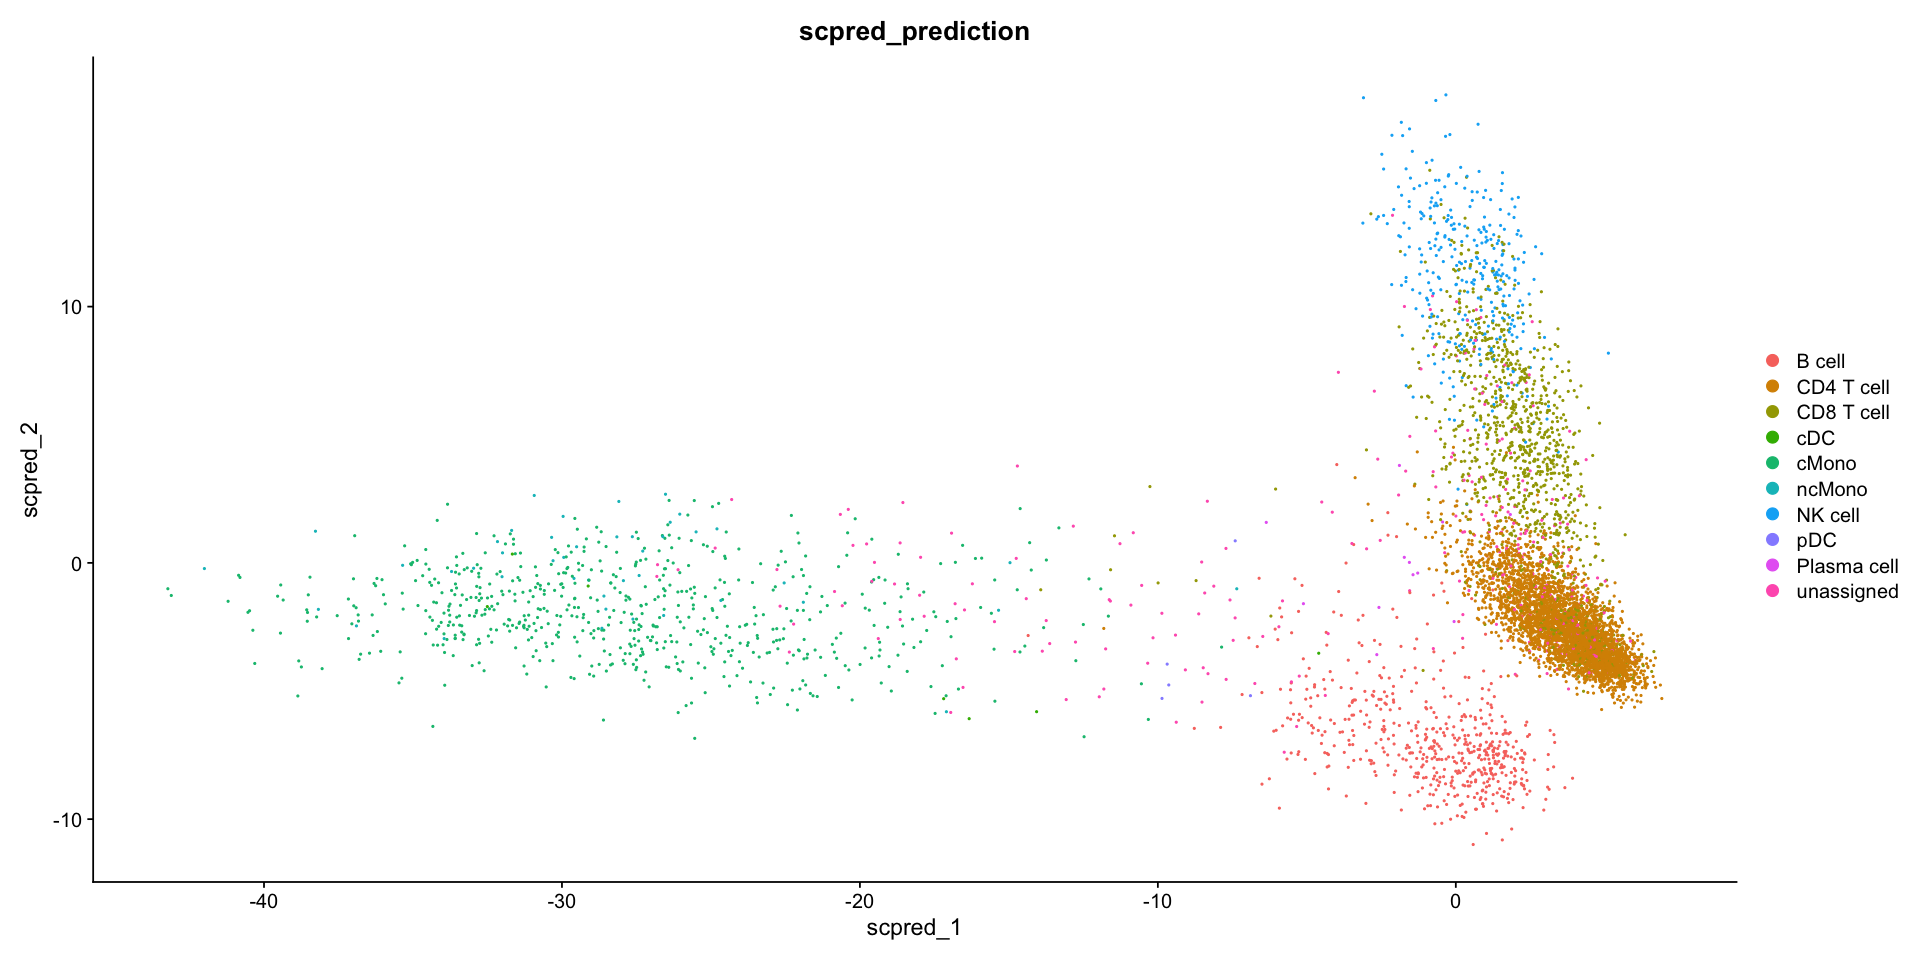

In [49]:
DimPlot(query, group.by = "scpred_prediction", reduction = "scpred")

In [50]:
query <- RunUMAP(query, reduction = "scpred", dims = 1:30)

16:04:50 UMAP embedding parameters a = 0.9922 b = 1.112

16:04:50 Read 6968 rows and found 30 numeric columns

16:04:50 Using Annoy for neighbor search, n_neighbors = 30

16:04:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:04:51 Writing NN index file to temp file /var/folders/cq/4gq41jhd0tbcx2l74n_7g0nw0000gn/T//RtmpIl0uKC/filefac9185c9484

16:04:51 Searching Annoy index using 1 thread, search_k = 3000

16:04:53 Annoy recall = 100%

16:04:53 Commencing smooth kNN distance calibration using 1 thread

16:04:54 Initializing from normalized Laplacian + noise

16:04:54 Commencing optimization for 500 epochs, with 322276 positive edges

16:05:03 Optimization finished



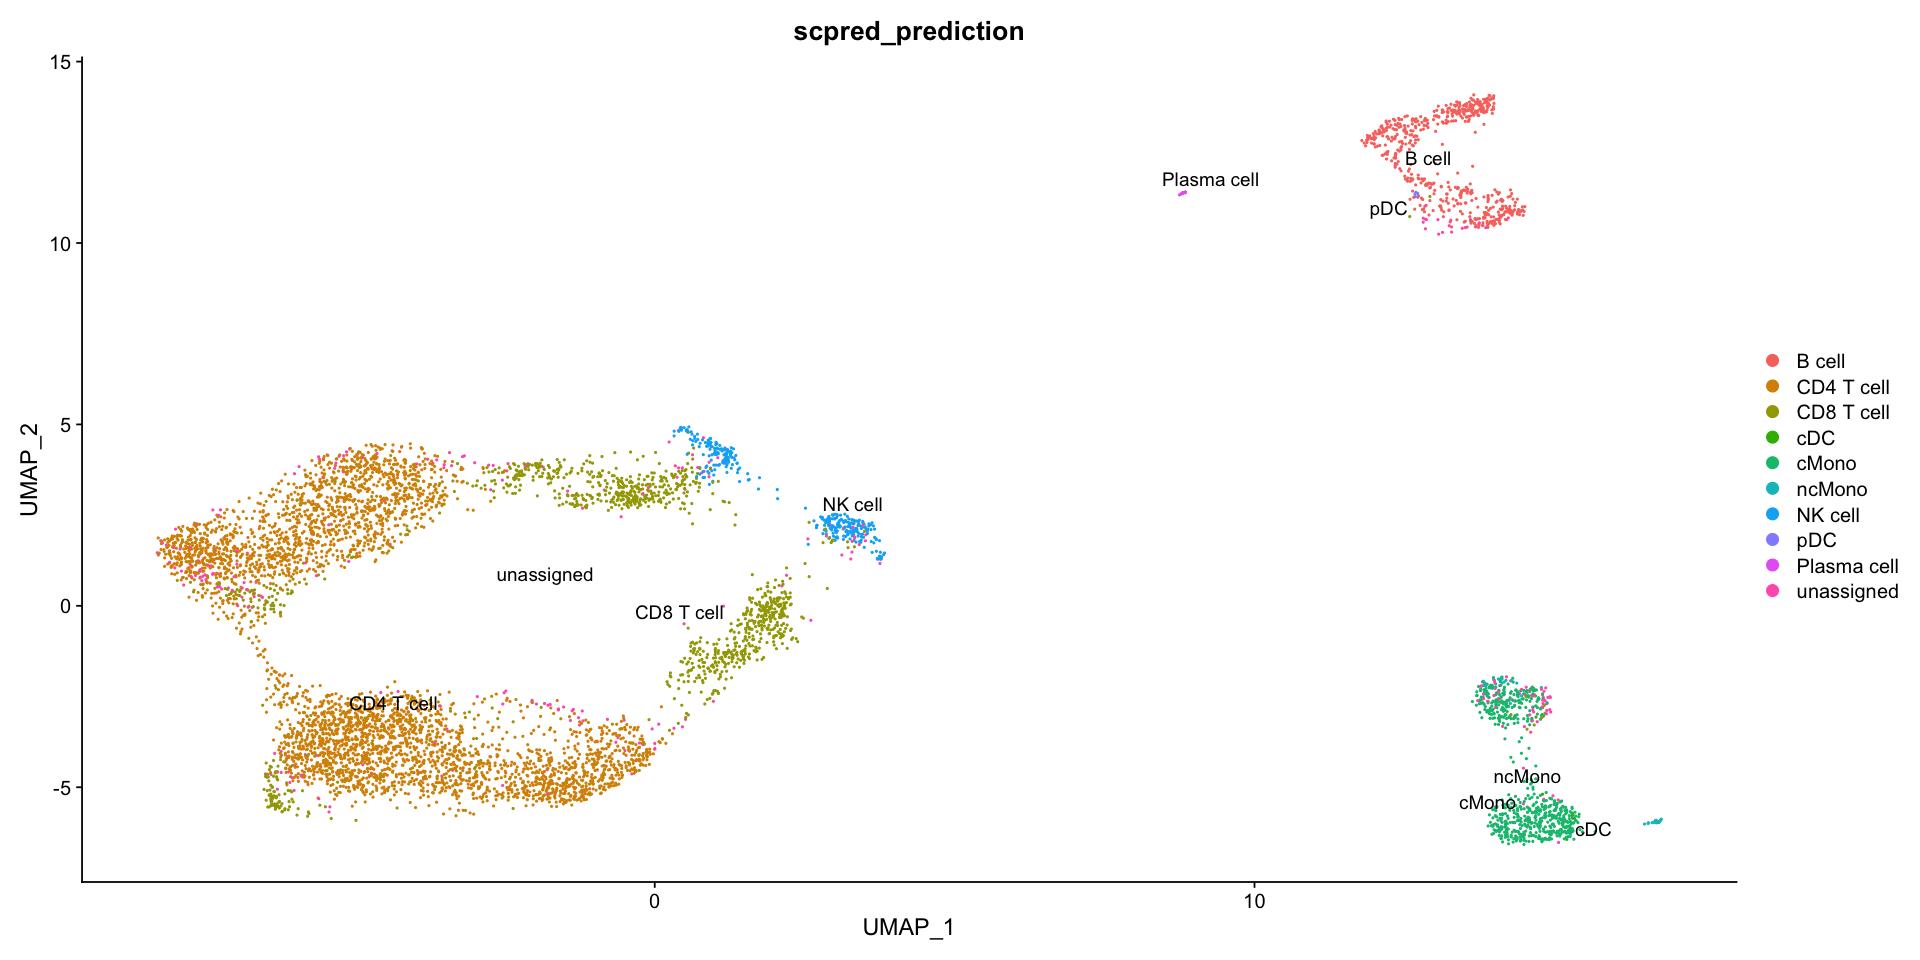

In [51]:
DimPlot(query, group.by = "scpred_prediction", label = TRUE, repel = TRUE)

In [69]:
#DimPlot(query, group.by = "cell_type", label = TRUE, repel = TRUE)

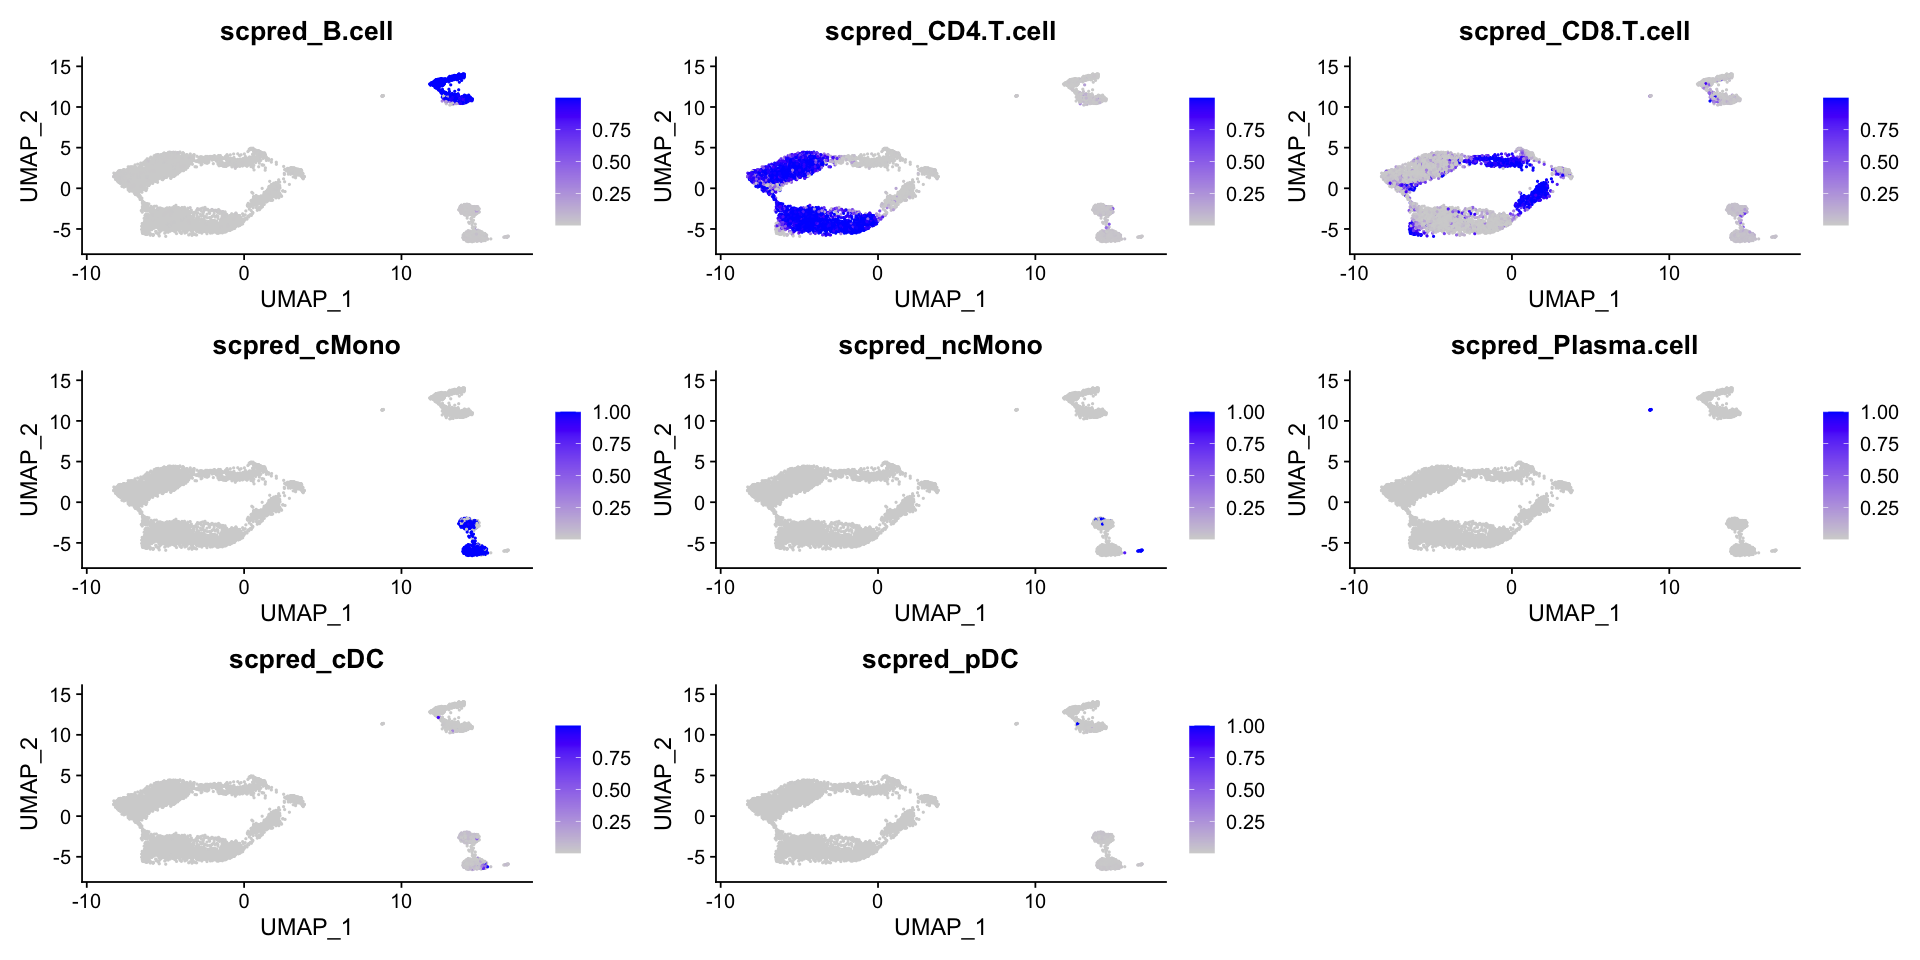

In [70]:
FeaturePlot(query, c("scpred_B.cell", "scpred_CD4.T.cell", "scpred_CD8.T.cell", 
                     "scpred_cMono", "scpred_ncMono", "scpred_Plasma.cell", 
                     "scpred_cDC", "scpred_pDC"))

In [64]:
#crossTab(query, "cell_type", "scpred_prediction")

In [71]:
#crossTab(query, "cell_type", "scpred_prediction", output = "prop")

In [107]:
x <- as.data.frame(query$scpred_prediction)

In [108]:
colnames(x) <- c('celltype')

In [109]:
rownames(x) <- gsub("-1", "", rownames(x))

In [110]:
rownames(x) <- gsub("^", "B1_c1_", rownames(x))

In [115]:
x$celltype <- gsub(" cell$","",x$celltype)

In [118]:
x$celltype <- gsub(" ","_",x$celltype)

In [121]:
x$celltype <- gsub("^cMono","monocytes",x$celltype)

In [122]:
x

celltype  
B1_c1_AAACCTGAGATCGGGT CD4_T     
B1_c1_AAACCTGAGCCAGAAC CD8_T     
B1_c1_AAACCTGAGCGTGAAC B         
B1_c1_AAACCTGCACTTGGAT CD4_T     
B1_c1_AAACCTGCAGACGCAA CD4_T     
B1_c1_AAACCTGGTAGAGCTG CD4_T     
B1_c1_AAACCTGGTATAATGG CD4_T     
B1_c1_AAACCTGGTCGTCTTC CD4_T     
B1_c1_AAACCTGGTGATGCCC CD4_T     
B1_c1_AAACCTGGTTTGTTGG CD4_T     
B1_c1_AAACCTGTCAAAGACA CD4_T     
B1_c1_AAACCTGTCACATAGC CD8_T     
B1_c1_AAACCTGTCACCACCT B         
B1_c1_AAACCTGTCCATTCTA monocytes 
B1_c1_AAACCTGTCTGCTGTC CD4_T     
B1_c1_AAACCTGTCTGGTGTA CD4_T     
B1_c1_AAACCTGTCTTGTTTG CD4_T     
B1_c1_AAACGGGAGATCGGGT CD4_T     
B1_c1_AAACGGGCAAGTAATG CD8_T     
B1_c1_AAACGGGCAGCTCCGA CD4_T     
B1_c1_AAACGGGCATGGTAGG CD8_T     
B1_c1_AAACGGGGTAGCGCTC CD4_T     
B1_c1_AAACGGGGTTCCAACA NK        
B1_c1_AAACGGGTCCTAGAAC CD8_T     
B1_c1_AAACGGGTCCTGTACC CD8_T     
B1_c1_AAACGGGTCGAACTGT CD4_T     
B1_c1_AAACGGGTCTGAGTGT CD4_T     
B1_c1_AAAGATGAGAGATGAG CD4_T     
B1_c1_AAAGATGAGGACGAAA B         
B1_c1_AAAGATGAGGCCCTTG CD4_T     
⋮                      ⋮         
B1_c1_TTTGCGCGTAGCACGA unassigned
B1_c1_TTTGCGCGTGATAAGT CD4_T     
B1_c1_TTTGCGCGTGGTCTCG CD8_T     
B1_c1_TTTGCGCTCCGCAGTG CD4_T     
B1_c1_TTTGGTTAGAAGATTC CD4_T     
B1_c1_TTTGGTTAGACTGTAA CD4_T     
B1_c1_TTTGGTTAGCTGCGAA CD4_T     
B1_c1_TTTGGTTAGGCATGGT CD4_T     
B1_c1_TTTGGTTCACATGACT CD4_T     
B1_c1_TTTGGTTGTAATCGTC unassigned
B1_c1_TTTGGTTGTGAGGGAG CD4_T     
B1_c1_TTTGGTTTCGAGCCCA CD4_T     
B1_c1_TTTGGTTTCGGTTAAC CD4_T     
B1_c1_TTTGGTTTCTGGTTCC CD8_T     
B1_c1_TTTGGTTTCTGTTGAG CD4_T     
B1_c1_TTTGGTTTCTTACCTA CD4_T     
B1_c1_TTTGTCAAGACGCACA CD4_T     
B1_c1_TTTGTCAAGACTTGAA CD4_T     
B1_c1_TTTGTCAAGCGATGAC CD4_T     
B1_c1_TTTGTCAAGTACTTGC CD4_T     
B1_c1_TTTGTCAAGTCAAGCG CD4_T     
B1_c1_TTTGTCAAGTTAACGA CD4_T     
B1_c1_TTTGTCACAATGGATA CD8_T     
B1_c1_TTTGTCACACAGACTT CD4_T     
B1_c1_TTTGTCACACTTAAGC CD8_T     
B1_c1_TTTGTCACAGCCAGAA CD8_T     
B1_c1_TTTGTCACATACCATG CD4_T     
B1_c1_TTTGTCACATGACATC CD4_T     
B1_c1_TTTGTCAGTCTAACGT CD4_T     
B1_c1_TTTGTCATCTAACCGA CD8_T

In [123]:
write.table(x, 'B1_c1_cell_types.csv', append = FALSE, sep = ",", dec = ".",
row.names = TRUE, col.names = FALSE, quote = FALSE )